# Analysis Workflow: Geospatial Distribution of Generalized Trust in Continental Europe

## Setting Up

First, we load in the libraries and tools we'll need, import the World Values Survey variable encodings and set parameters for visualization.

In [16]:
import esda
import seaborn
import libpysal
import warnings
import contextily
import jenkspy
import matplotlib_map_utils
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from matplotlib import (
    pyplot as plt,
    ticker,
    colors,
    patches,
    lines,
    patheffects,
)
from constants import (
    variable_response_mapping,
    variable_name_mapping,
)
plt.style.use("theme.mplstyle")

warnings.filterwarnings("ignore", message="There are no gridspecs with layoutgrids.*")

DATA_PATH   = Path(".") / ".." / "data"
OUTPUT_PATH = Path(".") / ".." / "output"

## Acquiring Geographic Data

Seeing as this is a spatial analysis, we'll need geographic data. We retrieve country boundary polygons along with useful metadata such as estimates for population and median gross domestic product from [Natural Earth](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/). This results in geospatial objects for 248 of what Natural Earth calls (de facto) countries.

Retrieved polygon and metadata for 248 countries/territories from Natural Earth


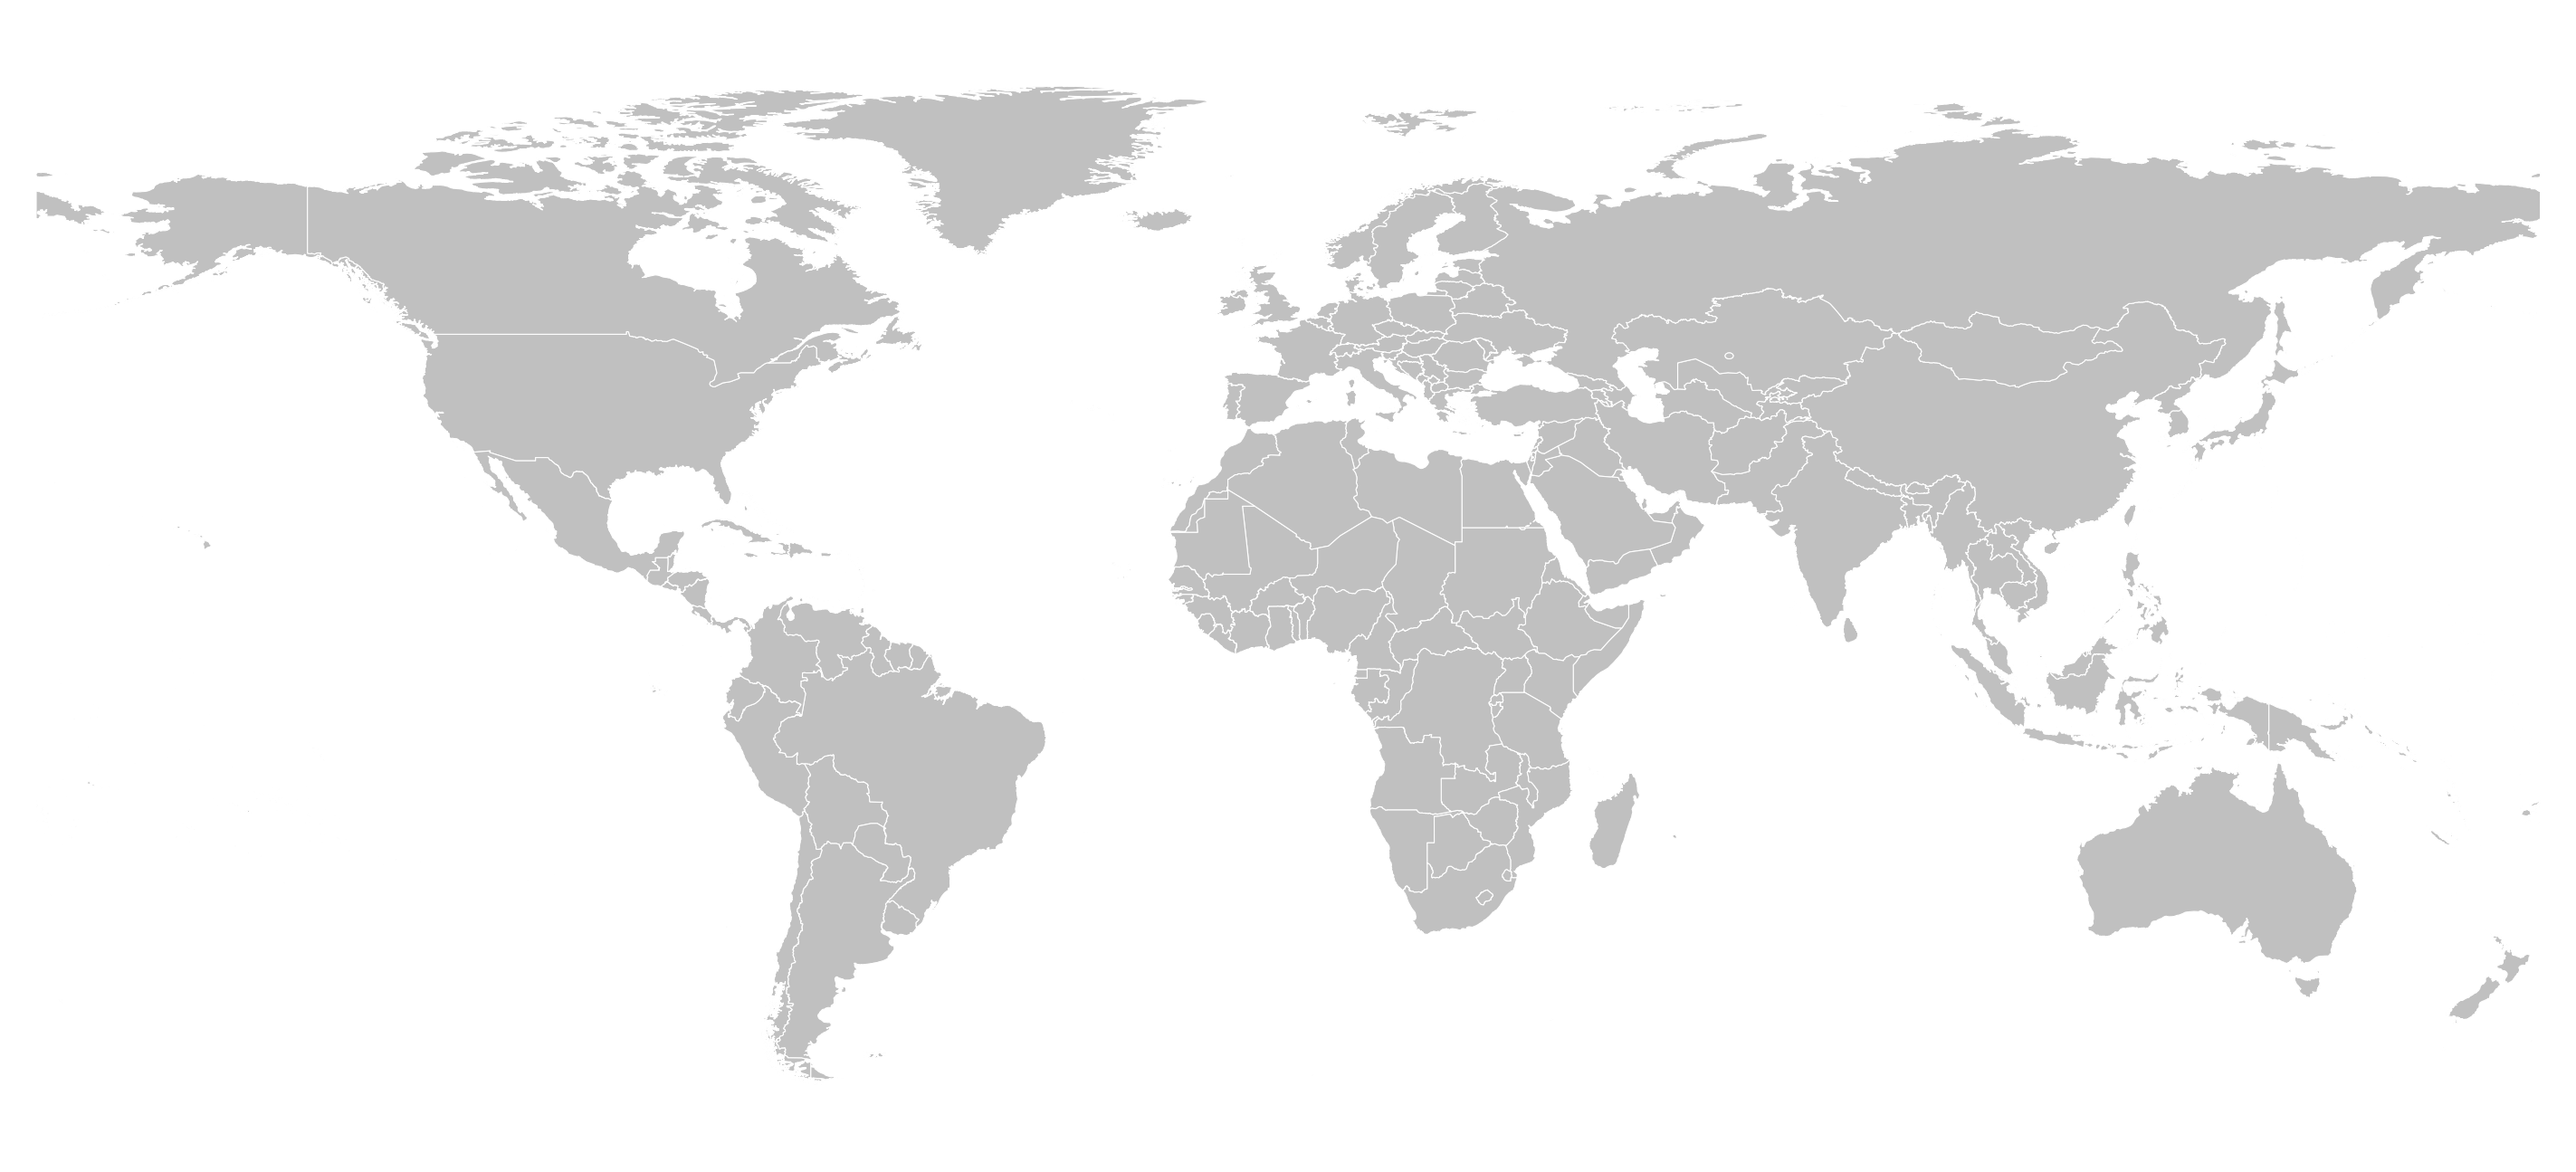

In [17]:
geodata = gpd.read_file(DATA_PATH / "country_boundaries_10m.zip")[[
    "NAME",
    "ISO_A2_EH",
    "ISO_A3_EH",
    "ISO_N3_EH",
    "CONTINENT",
    "POP_EST",
    "GDP_MD",
    "SOVEREIGNT",
    "geometry",
]].rename(columns=dict(
    NAME="country_name",
    ISO_A2_EH="country_iso3166_alpha2",
    ISO_A3_EH="country_iso3166_alpha3",
    ISO_N3_EH="country_iso3166_num",
    CONTINENT="continent",
    GDP_MD="median_gdp",
    POP_EST="population",
    SOVEREIGNT="sovereignty",
))
geodata["country_iso3166_num"] = geodata["country_iso3166_num"].astype(int)
geodata = geodata[geodata["continent"].isin([
    "Africa",
    "Asia",
    "Europe",
    "South America",
    "North America",
    "Oceania",
])]

print(f"Retrieved polygon and metadata for {len(geodata)} countries/territories from Natural Earth")
geodata.head(5)
geodata.plot(
    color="silver",
    edgecolor="white",
    linewidth=0.2,
)
plt.axis("off")
plt.show()

We than load in the raw tabular dataset from the World Values Survey (WWS) and recode values according to the WWS codebook. The dataset consists of more than 150 000 rows, one per interviewee. We then join some of the metadata from Natural Earth onto this dataframe as this will be useful when aggregating the data by country. Spatial geometries are not added at this stage, as this would be _very_ memory intensive. 

In [ ]:
def prepare_wws_data(raw_data_path, country_metadata):
    """
    load the raw World Values Survey results, recode raw values according to codebook and append metadata from Natural Earth
    """
    dataset = pd.read_csv(raw_data_path, low_memory=False)

    dataset.columns = map(str.upper, dataset.columns)
    dataset[dataset.select_dtypes(np.number).columns] = dataset[dataset.select_dtypes(np.number).columns].map(lambda val: val if val > 0 else pd.NA)

    for variable, mapping in variable_response_mapping.items():
        dataset[variable] = dataset[variable].map(mapping)
    dataset = dataset[variable_name_mapping.keys()].rename(columns=variable_name_mapping)

    dataset = dataset[dataset["citizenship"] == True] # only consider interviewees citizens of each country

    dataset["interview_date"] = pd.to_datetime(dataset["interview_date"], format="%Y%m%d", errors="coerce")
    dataset["country_iso3166_num"] = dataset["country_iso3166_num"].astype(int)

    dataset = dataset.set_index("country_iso3166_alpha2").join(country_metadata.drop(columns=["country_iso3166_alpha3", "country_iso3166_num"]).set_index("country_iso3166_alpha2"), how="left").reset_index()

    return dataset

RAW_WWS_DATASET_PATH        = DATA_PATH / "EVS_WVS_Joint_Csv_v5_0.csv"
PROCESSED_WWS_DATASET_PATH  = DATA_PATH / "wws_dataset.csv"

if RAW_WWS_DATASET_PATH.exists():
    dataset = prepare_wws_data(
        raw_data_path=RAW_WWS_DATASET_PATH,
        country_metadata=geodata.drop(columns="geometry"),
    )
    dataset.to_csv(PROCESSED_WWS_DATASET_PATH, index=False)
else:
    dataset = pd.read_csv(PROCESSED_WWS_DATASET_PATH)
dataset.info()
dataset

## Aggregating Relative Generalized Trust by Country

We then compute the relative proportion of respondents (Relative Generalized Trust; RTG) in each country who responded to the Generalized Trust Question (GTQ) with "Most people can be trusted."

In [ ]:
GTQ_question = "most_people_trustworthy"
target_answer = "Most people can be trusted"

grouping_criteria = [
    "country_name", 
    "country_iso3166_alpha2",
    "continent", 
    "population",
    "median_gdp",
]

by_country_dataset = dataset.groupby(grouping_criteria)[GTQ_question].value_counts(dropna=True).to_frame("target_responses").reset_index()
by_country_dataset["total_responses"] = by_country_dataset.groupby(grouping_criteria)["target_responses"].transform("sum")
by_country_dataset["RGT"] = by_country_dataset["target_responses"] / by_country_dataset.groupby(grouping_criteria)["target_responses"].transform("sum")
by_country_dataset["RGT_sigma"] = by_country_dataset[["target_responses", "RGT"]].apply(lambda row: np.sqrt((row["RGT"] * (1 - row["RGT"])) / row["target_responses"]), axis=1)
by_country_dataset["sampling_fraction"] = by_country_dataset["total_responses"] / by_country_dataset["population"]

RGTs = by_country_dataset[by_country_dataset[GTQ_question] == target_answer].sort_values(by="RGT", ascending=False).drop(columns=GTQ_question)

We can then look at which European countries seem to top the charts and which are towards the bottom when it comes to RTG.

In [ ]:
RGTs_europe = RGTs[RGTs["continent"] == "Europe"]

print(f"Top five and bottom five of the {len(RGTs_europe)} European countries with data for RGT:")
pd.concat([
    RGTs_europe.head(),
    RGTs_europe.tail(),
]).drop(columns=[
    "country_iso3166_alpha2",
    "continent",
    "population",
    "median_gdp",
]).set_index("country_name").round(3)

Top five and bottom five of the 35 European countries with data for RGT:


target_responses  total_responses    RGT  RGT_sigma  \
country_name                                                            
Denmark                       2479             3189  0.777      0.008   
Norway                         767             1006  0.762      0.015   
Finland                        849             1174  0.723      0.015   
Sweden                         767             1130  0.679      0.017   
Iceland                       1028             1552  0.662      0.015   
North Macedonia                159             1052  0.151      0.028   
Romania                        355             2813  0.126      0.018   
Bosnia and Herz.               163             1696  0.096      0.023   
Greece                          97             1143  0.085      0.028   
Albania                         35             1422  0.025      0.026   

                  sampling_fraction  
country_name                         
Denmark                       0.001  
Norway                        0.000  
Finland                       0.000  
Sweden                        0.000  
Iceland                       0.004  
North Macedonia               0.001  
Romania                       0.000  
Bosnia and Herz.              0.001  
Greece                        0.000  
Albania                       0.000

We can show this visually using a bar chart, sorted by level of RGT, which gives some idea of what is going in terms of geographic distribution. But we'll need geographic data to get the larger picture.

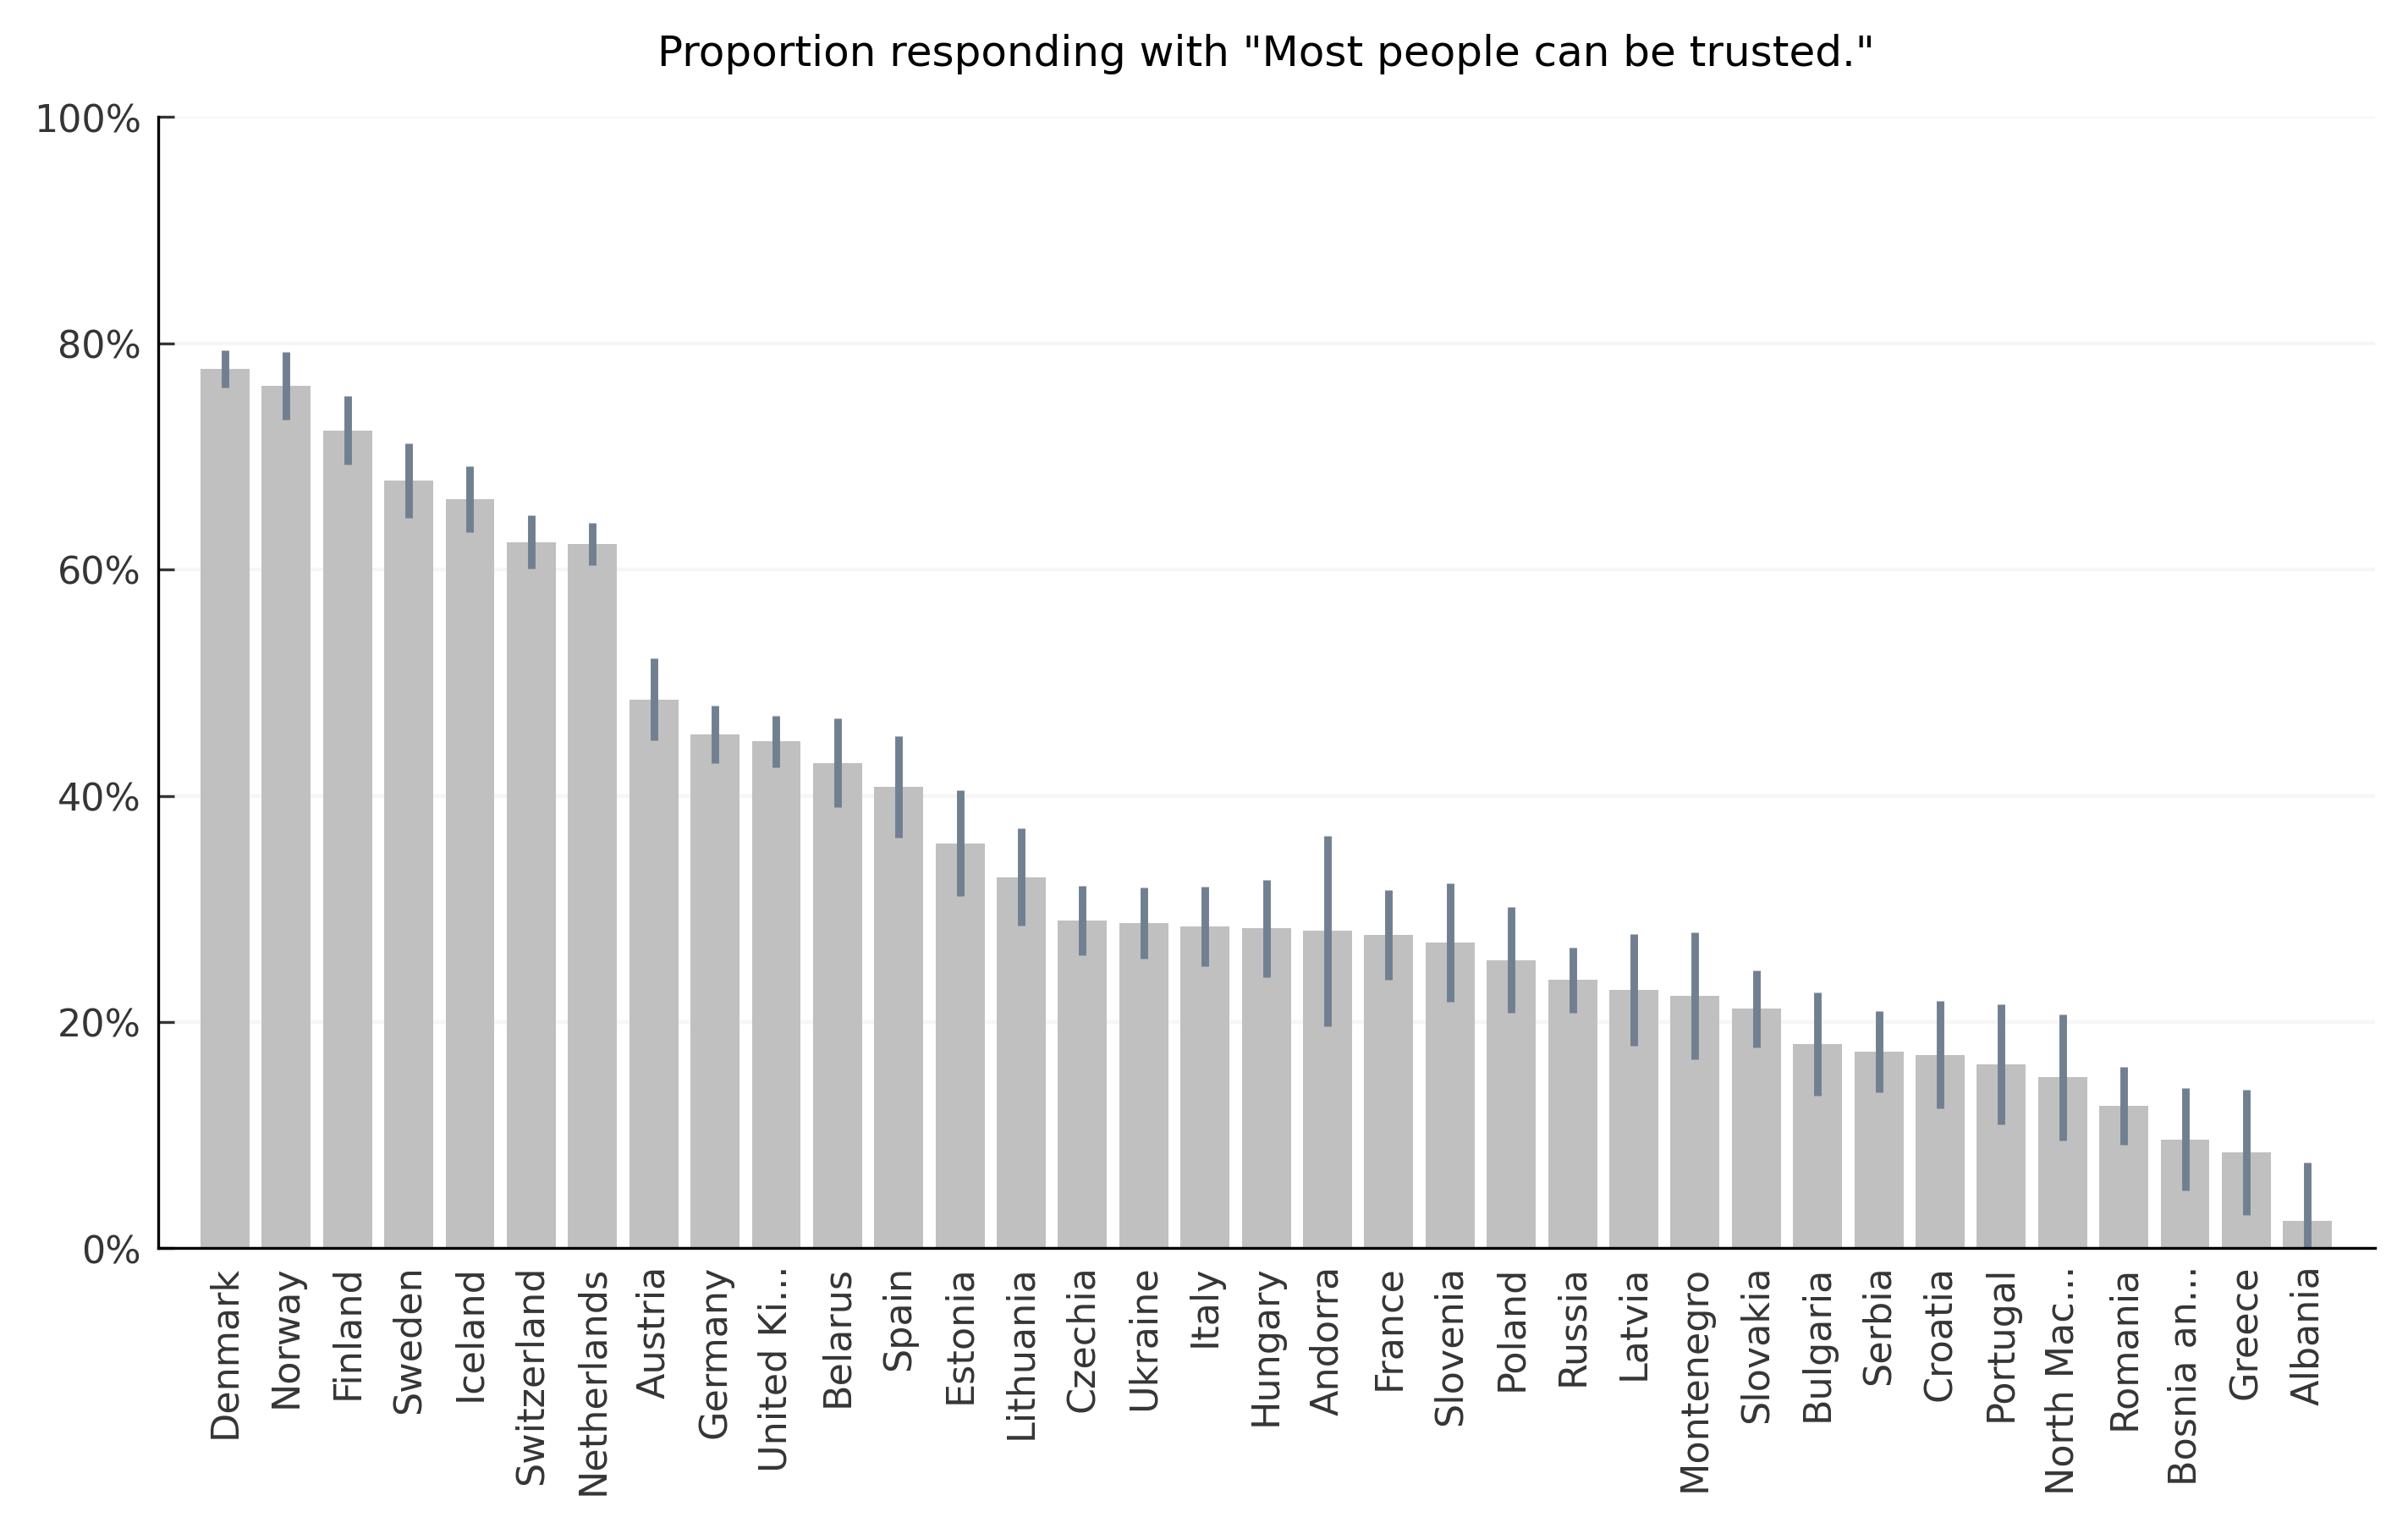

In [ ]:
def bar_chart(RGTs):
    plt.bar(
        RGTs["country_name"],
        RGTs["RGT"],
        color="silver",
    )
    plt.errorbar(
        RGTs["country_name"],
        RGTs["RGT"],
        yerr=1.96 * RGTs["RGT_sigma"],
        color="slategrey",
        barsabove=True,
        linestyle="none",
    )

    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.xlabel("")
    plt.margins(x=0.02)
    plt.ylim(0, 1)
    plt.xticks(
        range(len(RGTs)), 
        [label[:9] + "..." if len(label) > 12 else label for label in RGTs["country_name"]],
        rotation=90,
        # rotation=45,
        # ha="right",
    )
    plt.title(
        f'Proportion responding with "{target_answer}."',
        size=9,
        weight="normal",
    )
    plt.savefig(OUTPUT_PATH / "bar_chart.png", bbox_inches="tight")
    plt.show()

bar_chart(
    RGTs=RGTs_europe,
)

### Going Spatial

We'll now need to associate these observations of RGT with geographic locations and situate them in a spatial sense.
We join the country polygon geometries with the country aggregated levels of RGT, using the two-letter alphabetic ISO-3166 identifier as the key between the two dataframes.

We then project the Natural Earth data, which is given in WGS-84 (EPSG:4326) into the Web/Pseudo Mercator projection (EPSG:3857) to obtain planar coordinates.
This projection is chosen strictly because it is well-known and common for visualization, which is the main use in this instance, whereas areal and distance accuracies are secondary.

In [ ]:
RGT_geodata = geodata.set_index("country_iso3166_alpha2")[["geometry"]].join(RGTs.set_index("country_iso3166_alpha2"), how="left")

RGT_geodata = RGT_geodata.to_crs(
    crs="EPSG:3857",    # Pseudo/Web-Mercator
    # crs="EPSG:54001",   # Plate Carree equidistant (azimuthal)
    # crs="ESRI:54009",   # Mollweide equal-area (cylindrical)
)

We then derive a spatial clipping mask of continental Europe and its immediate neighbours. This is implemented by constructing a buffer of approximately 250 km (not 250 km in a strict sense due to our projection) around a convex hull spanning the collective perimeter of Iceland, Greece and Ukraine, then masking the spatial dataframe by the rectangular extent of that buffer.

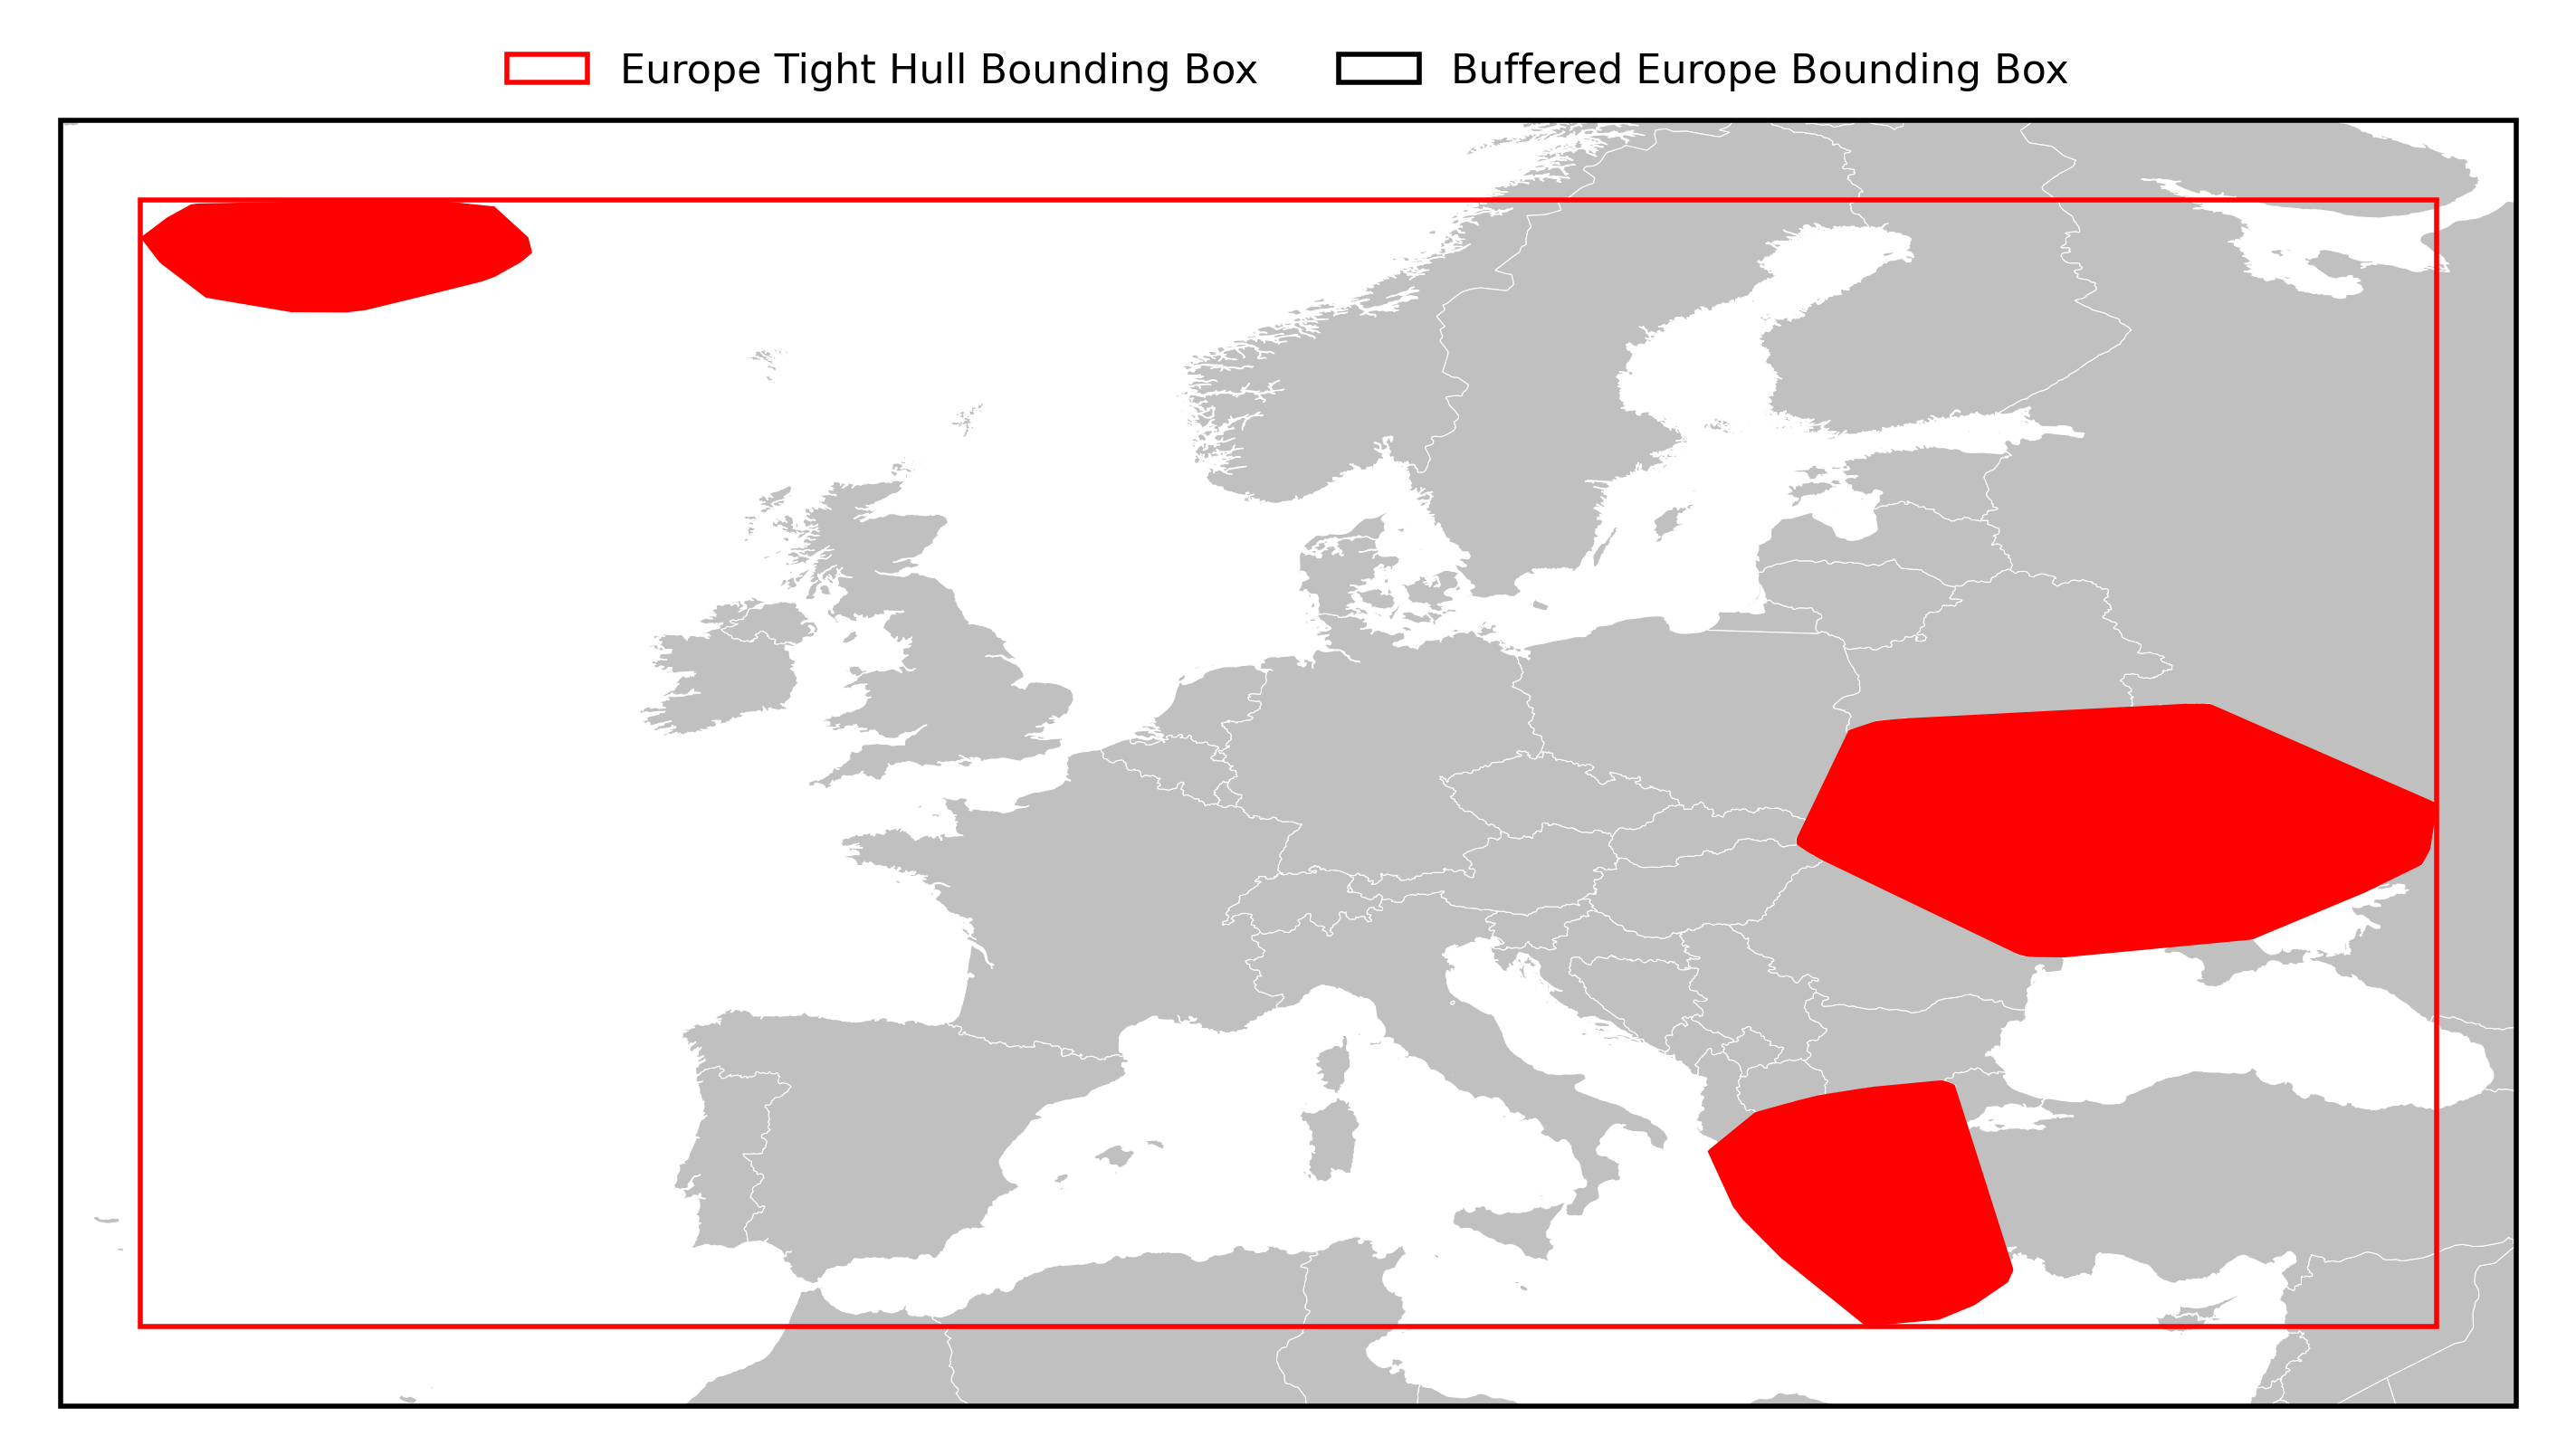

In [ ]:
continental_europe_hull = RGT_geodata[RGT_geodata["country_name"].isin([
    "Iceland",
    "Greece",
    "Ukraine",
])].convex_hull
continental_europe_bbox = continental_europe_hull.union_all().envelope

buffer_size = 250_000 # approximately 250 km

RGT_geodata_continental_europe = RGT_geodata.clip(mask=continental_europe_bbox.buffer(distance=buffer_size).bounds)

ax = RGT_geodata_continental_europe.plot(
    color="silver",
    edgecolor="white",
    linewidth=0.2,
    zorder=-1,
)
continental_europe_hull.plot(
    color="red",
    ax=ax,
)
bbox_bounds = continental_europe_bbox.bounds
ax.add_patch(
    patches.Rectangle(
        xy=(bbox_bounds[0], bbox_bounds[1]),
        width=bbox_bounds[2] - bbox_bounds[0],
        height=bbox_bounds[3] - bbox_bounds[1],
        edgecolor="red",
        label="Europe Tight Hull Bounding Box",
    )
)
buffered_bbox_bounds = continental_europe_bbox.buffer(distance=buffer_size).bounds
ax.add_patch(
    patches.Rectangle(
        xy=(buffered_bbox_bounds[0], buffered_bbox_bounds[1]),
        width=buffered_bbox_bounds[2] - buffered_bbox_bounds[0],
        height=buffered_bbox_bounds[3] - buffered_bbox_bounds[1],
        edgecolor="black",
        label="Buffered Europe Bounding Box",
    )
)
ax.legend(
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.07),
)
ax.margins(x=0.01, y=0.01)
plt.axis("off")
plt.show()

## Visualizing Geospatial Attribute Data

We can now plot a choropleth map of the RGT levels across continental Europe.

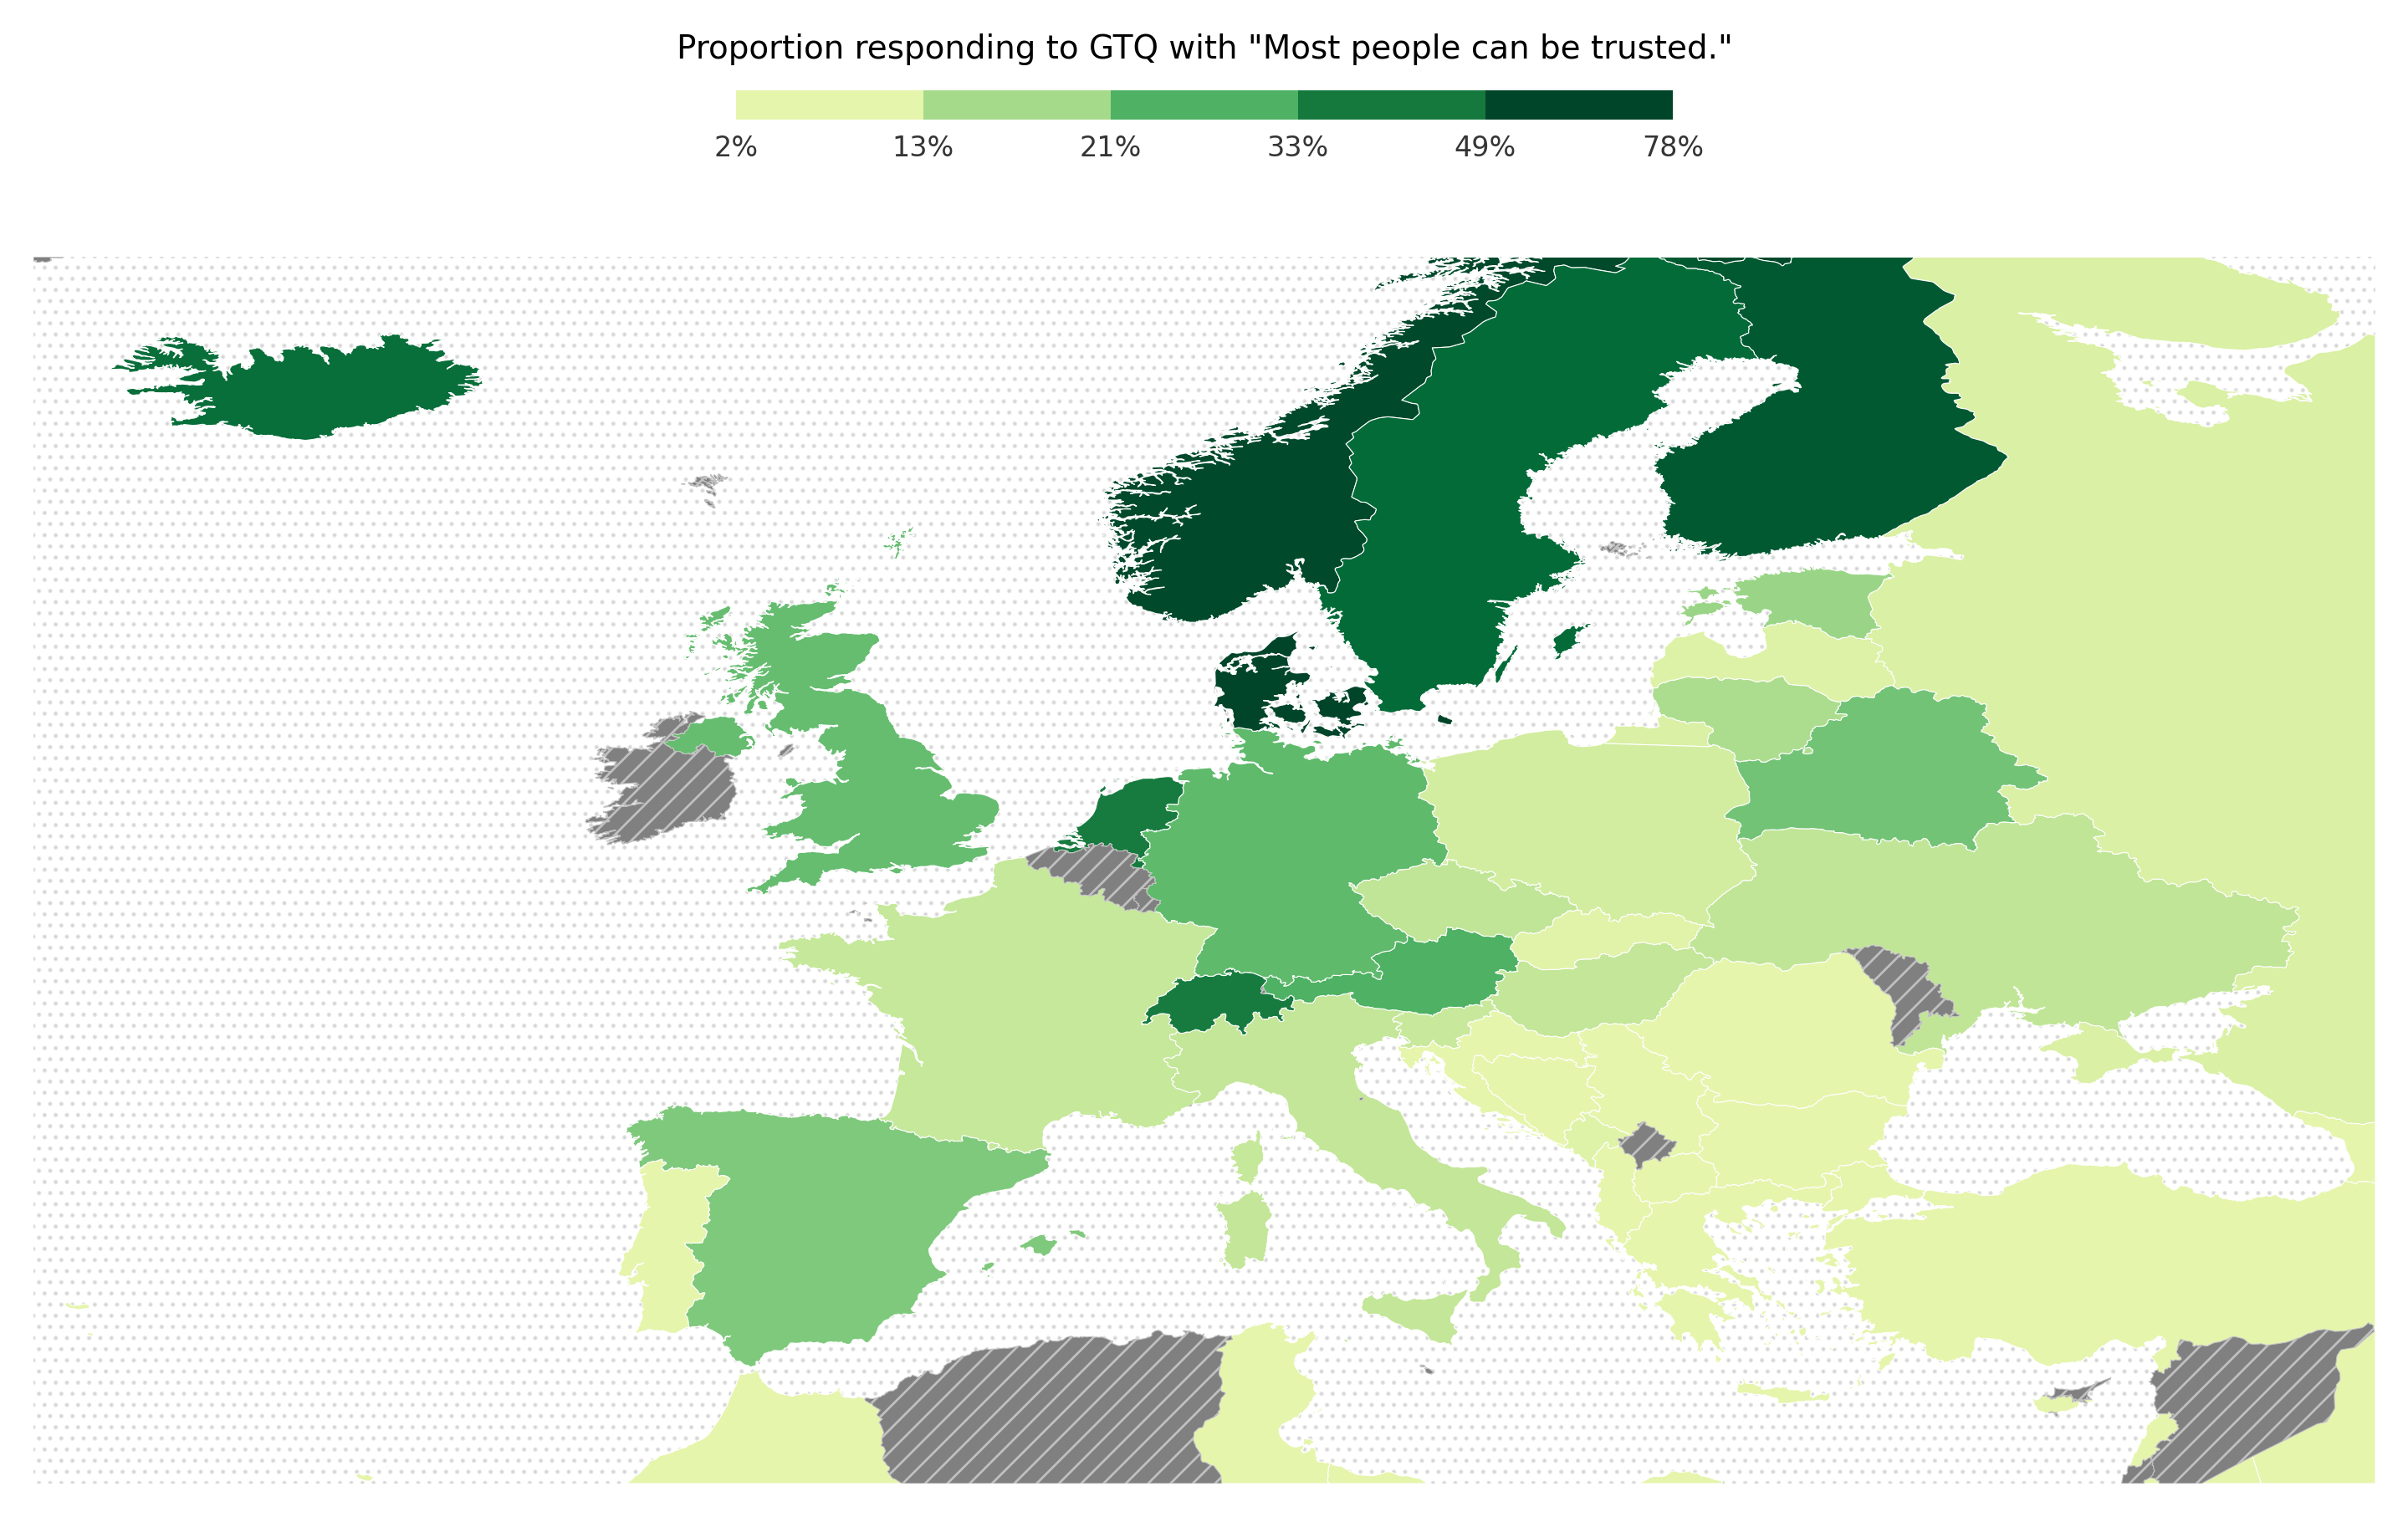

In [ ]:
def add_sea_pattern(ax):
    ax.add_patch(patches.Rectangle(
        (0, 0), 1, 1, 
        fill=False, 
        hatch=5 * ".", 
        color="grey",
        edgecolor=None,
        linewidth=0,
        clip_on=False,
        alpha=0.2,
        transform=ax.transAxes,
        zorder=-1,
    ))

def add_minimap(geodata, ax):
    inset_ax = matplotlib_map_utils.inset_map(
        ax=ax, 
        location="lower left", 
        coords=(0.03, 0.05),
        size=0.8,
        pad=1,
        xticks=[],
        yticks=[],
    )
    inset_ax.set_aspect(1)
    inset_ax.spines[["top", "right", "bottom", "left"]].set_visible(True)
    inset_ax.spines[["top", "right", "bottom", "left"]].set_linewidth(0.2)
    inset_ax.spines[["top", "right", "bottom", "left"]].set_alpha(0.5)
    matplotlib_map_utils.indicate_extent(
        pax=inset_ax, 
        bax=ax, 
        pcrs=geodata.crs,
        bcrs=geodata.crs,
        alpha=0.4,
        linewidth=0.5,
        facecolor="grey",
    )
    contextily.add_basemap(
        source="CartoDB.Positron.NoLabels",
        crs=geodata.crs,
        attribution="",
        ax=inset_ax, 
       reset_extent=False,
        zoom=0,
    )

def plot_choropleth(geodata, cmap=colors.ListedColormap(plt.get_cmap("YlGn")(np.linspace(0.2, 1, 100)))):
    fig = plt.figure(layout="none")
    ax = fig.add_axes(rect=(0, 0, 1, 0.92))
    cax = fig.add_axes(rect=(0.3, 0.97, 0.4, 0.02))

    ax = geodata.plot(
        column="RGT",
        missing_kwds=dict(
            color="grey",
            edgecolor="silver",
            hatch=5 * "/",
            linewidth=0.2,
        ),
        cmap=cmap,
        edgecolor="white",
        linewidth=0.2,
        vmin=0.2,
        ax=ax,
    )
    cbar = fig.colorbar(
        mappable = plt.cm.ScalarMappable(
            cmap=cmap, 
            norm=colors.BoundaryNorm(
                boundaries=jenkspy.jenks_breaks(geodata["RGT"].dropna(), n_classes=5), 
                ncolors=len(cmap.colors),
            ),
        ),
        location="bottom",
        pad=0.03,
        format="{x:.0%}",
        # spacing="proportional",
        cax=cax,
    )

    add_sea_pattern(ax=ax)
    add_minimap(geodata, ax=ax)

    cbar.outline.set_linewidth(0)
    cax.tick_params(
        labelsize=6, 
        length=0,
        pad=3,
    )
    cax.set_title(
        f'Proportion responding to GTQ with "{target_answer}."', 
        size=7,
        pad=7,
        weight="normal",
    )

    ax.margins(x=0, y=0)
    ax.axis("off")
    fig.savefig(OUTPUT_PATH / "choropleth.png", bbox_inches="tight")
    fig.show()

plot_choropleth(
    RGT_geodata_continental_europe,
)

## Spatial Analysis

Map visualization is all well and good, but it's difficult to interpret in a statistical sense, specifically because of having to take into account spatial autocorrelation.

### Deriving Spatial Weights

To reason about spatial autocorrelation, we will need some way to quantify the extent to which observations in space may have influenced each other. This is done with spatial weighting, which we will derive from a K-nearest neigbours (KNN) criterion under the assumption that a country's RGT is partially a product of its nearest neighbours, e.g. due to cultural spillover. For each country, we can look at how the neigbourhood connection graph looks if we consider, e.g., the fivest nearest neighbours (based on the centroid point of each country).

N.B.: centroids for non-European countries are computed from the part of the landmass that is inside our spatial region of interest, which is a somewhat contentious methodological choice, although it arguably has the intended effect in this instance.

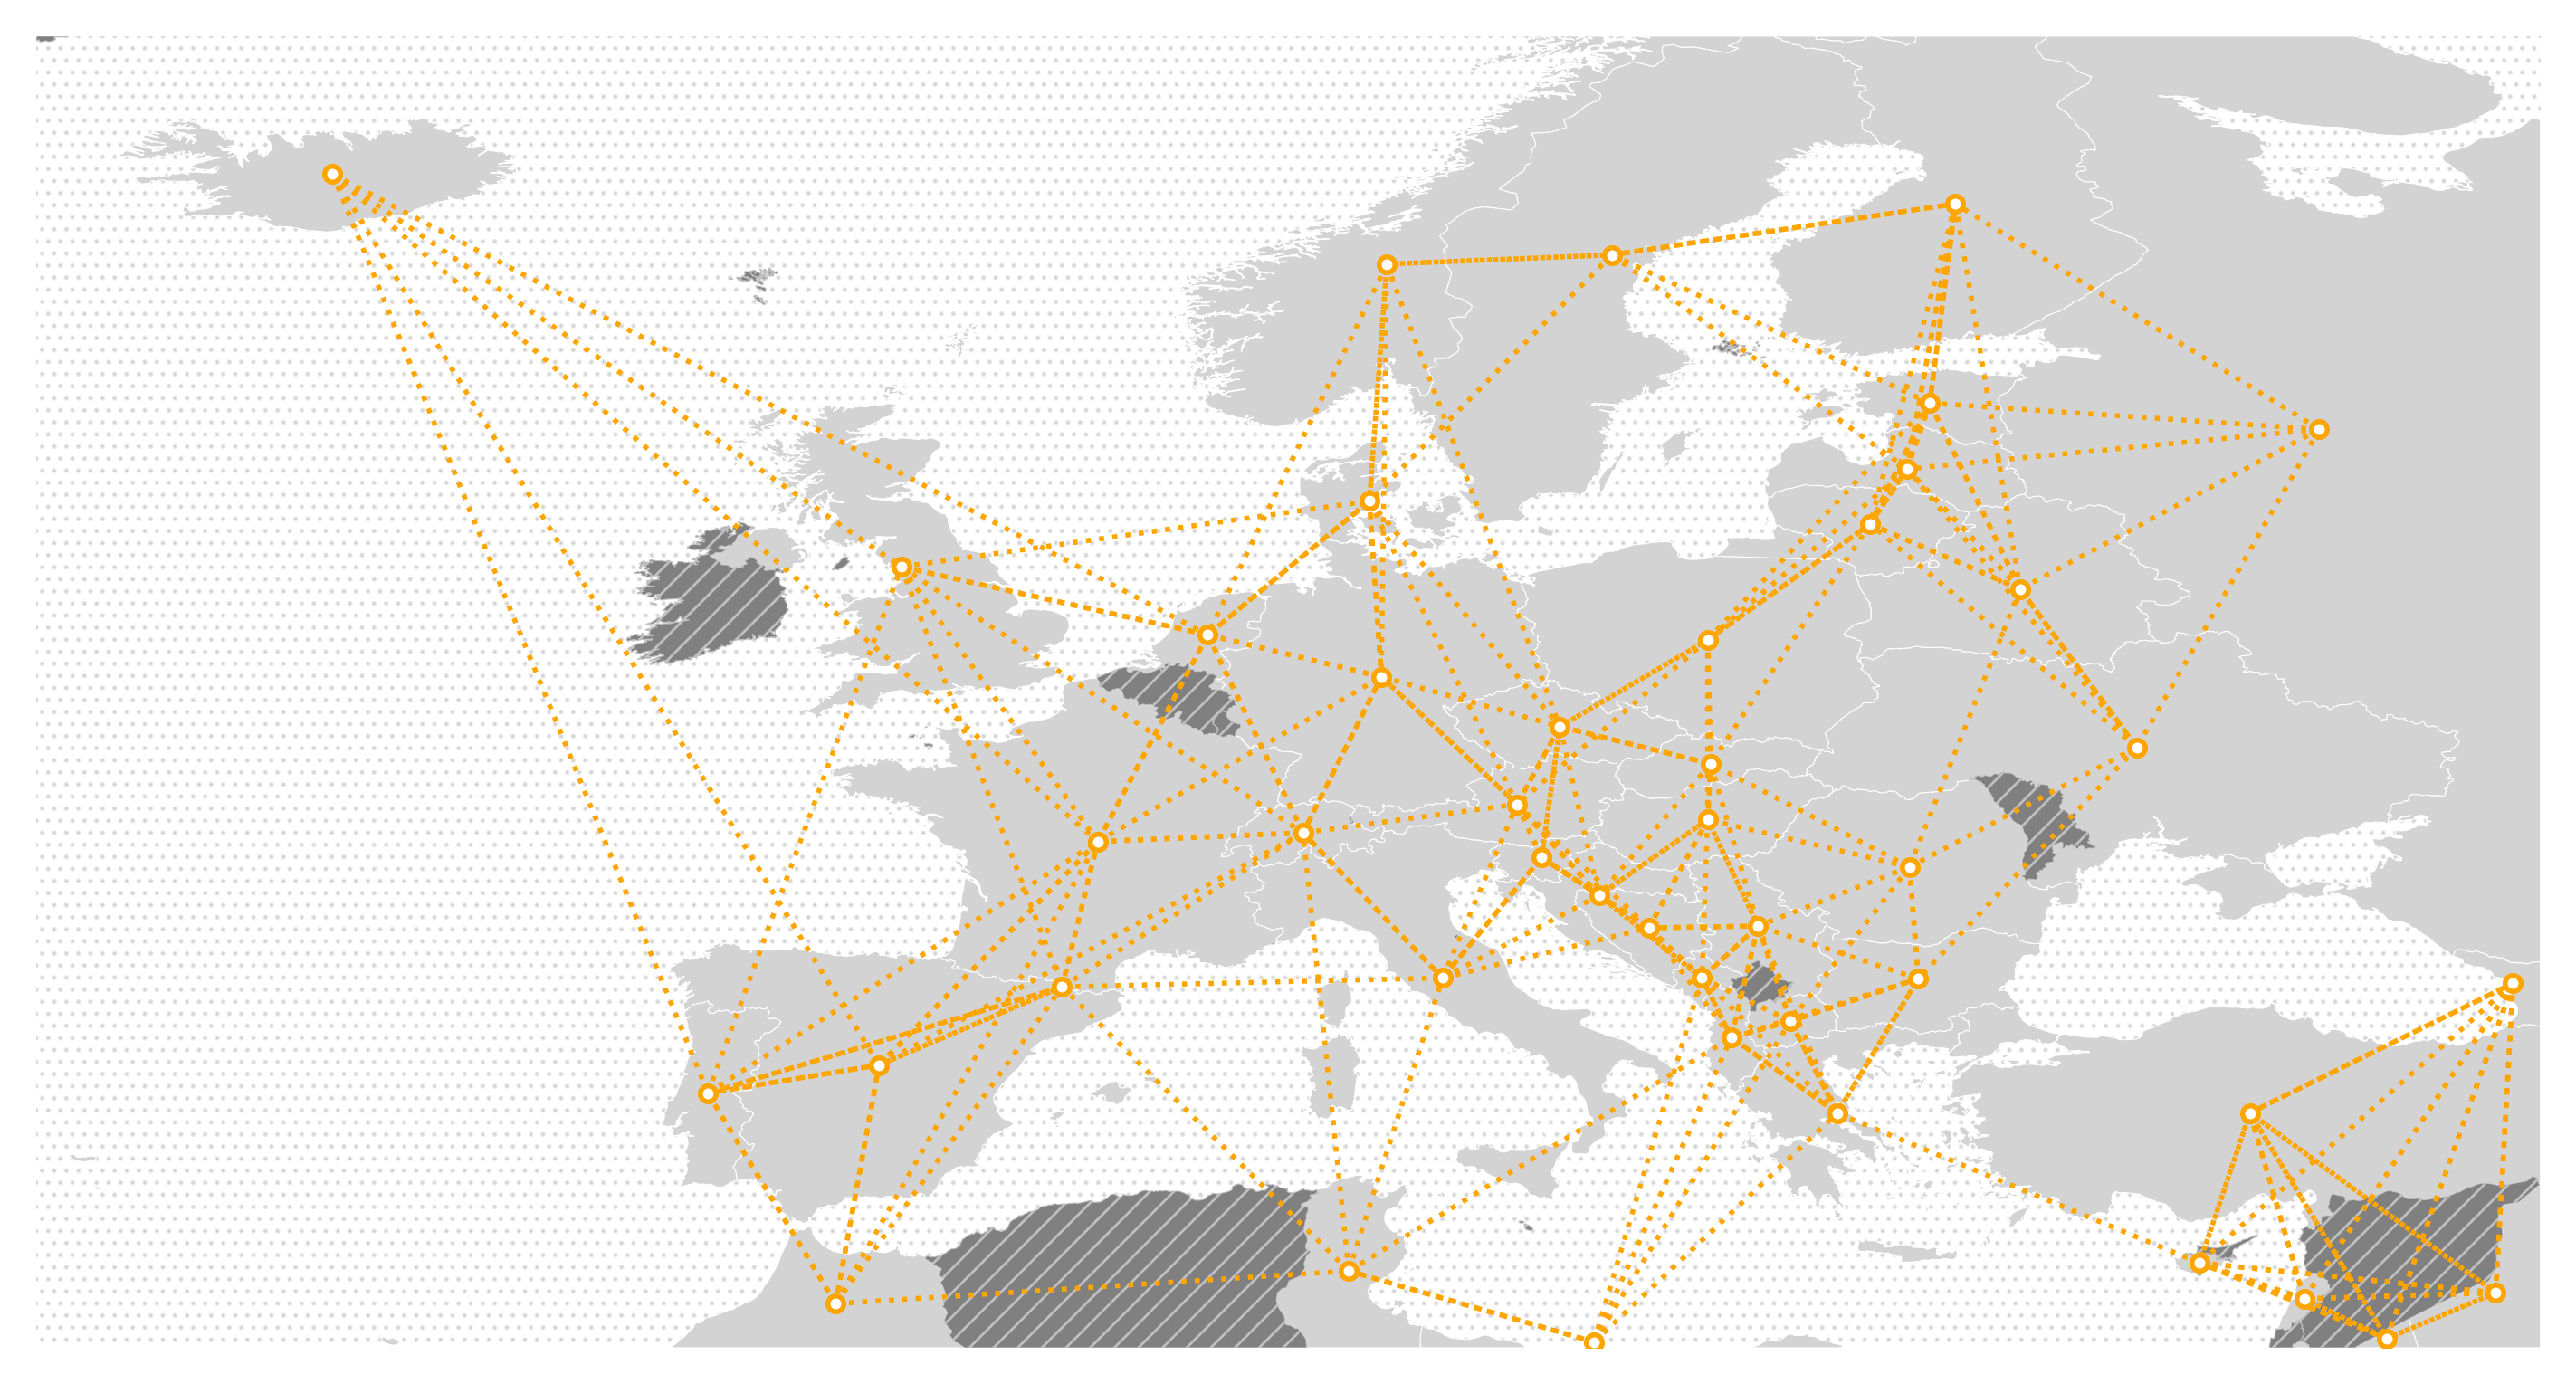

In [ ]:
def get_weights(data, criterion_function, args):
    """
    compute spatial weights from a given criterion
    """
    weights = criterion_function.from_dataframe(
        df=data.assign(geometry=data.centroid), 
        **args,
    )
    weights.origin_geodata = data
    return weights

def plot_weights(geodata, weights):
    ax = geodata.plot(
        color="lightgrey",
        edgecolor="white",
        linewidth=0.2,
    )
    ax = geodata[geodata["RGT"].isna()].plot(
        color="grey",
        edgecolor="silver",
        hatch=5 * "/",
        linewidth=0.2,
        ax=ax,
    )
    weights.plot(
        weights.origin_geodata,
        edge_kws=dict(color="orange", linestyle=":", linewidth=1),
        node_kws=dict(color="orange", marker="o", s=10, linewidth=1, facecolor="white", zorder=3),
        ax=ax,
    )
    add_sea_pattern(ax=ax)
    add_minimap(geodata, ax=ax)

    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.gcf().savefig(OUTPUT_PATH / "neighbours_graph.png", bbox_inches="tight")
    plt.show()

non_na_RGT_geodata_europe = RGT_geodata_continental_europe[~RGT_geodata_continental_europe["RGT"].isna()].reset_index()

five_nearest_weighting = get_weights(
    data=non_na_RGT_geodata_europe,
    criterion_function=libpysal.weights.KNN,
    args=dict(k=5) # consider 5 nearest-neighbours when deriving weights
)

plot_weights(
    RGT_geodata_continental_europe,
    weights=five_nearest_weighting,
)

### Global Moran's $I$

We can now perform a Global Moran's $I$ analysis (using the 5 nearest neighbour-derived weights) to ascertain whether the RGT dispersal pattern seen in our choropleth map could have plausibly arisen under the condititions of complete spatial randomness (CSR), or whether this is unlikely to be the case, hinting at a meaningful underlying data-generating process.

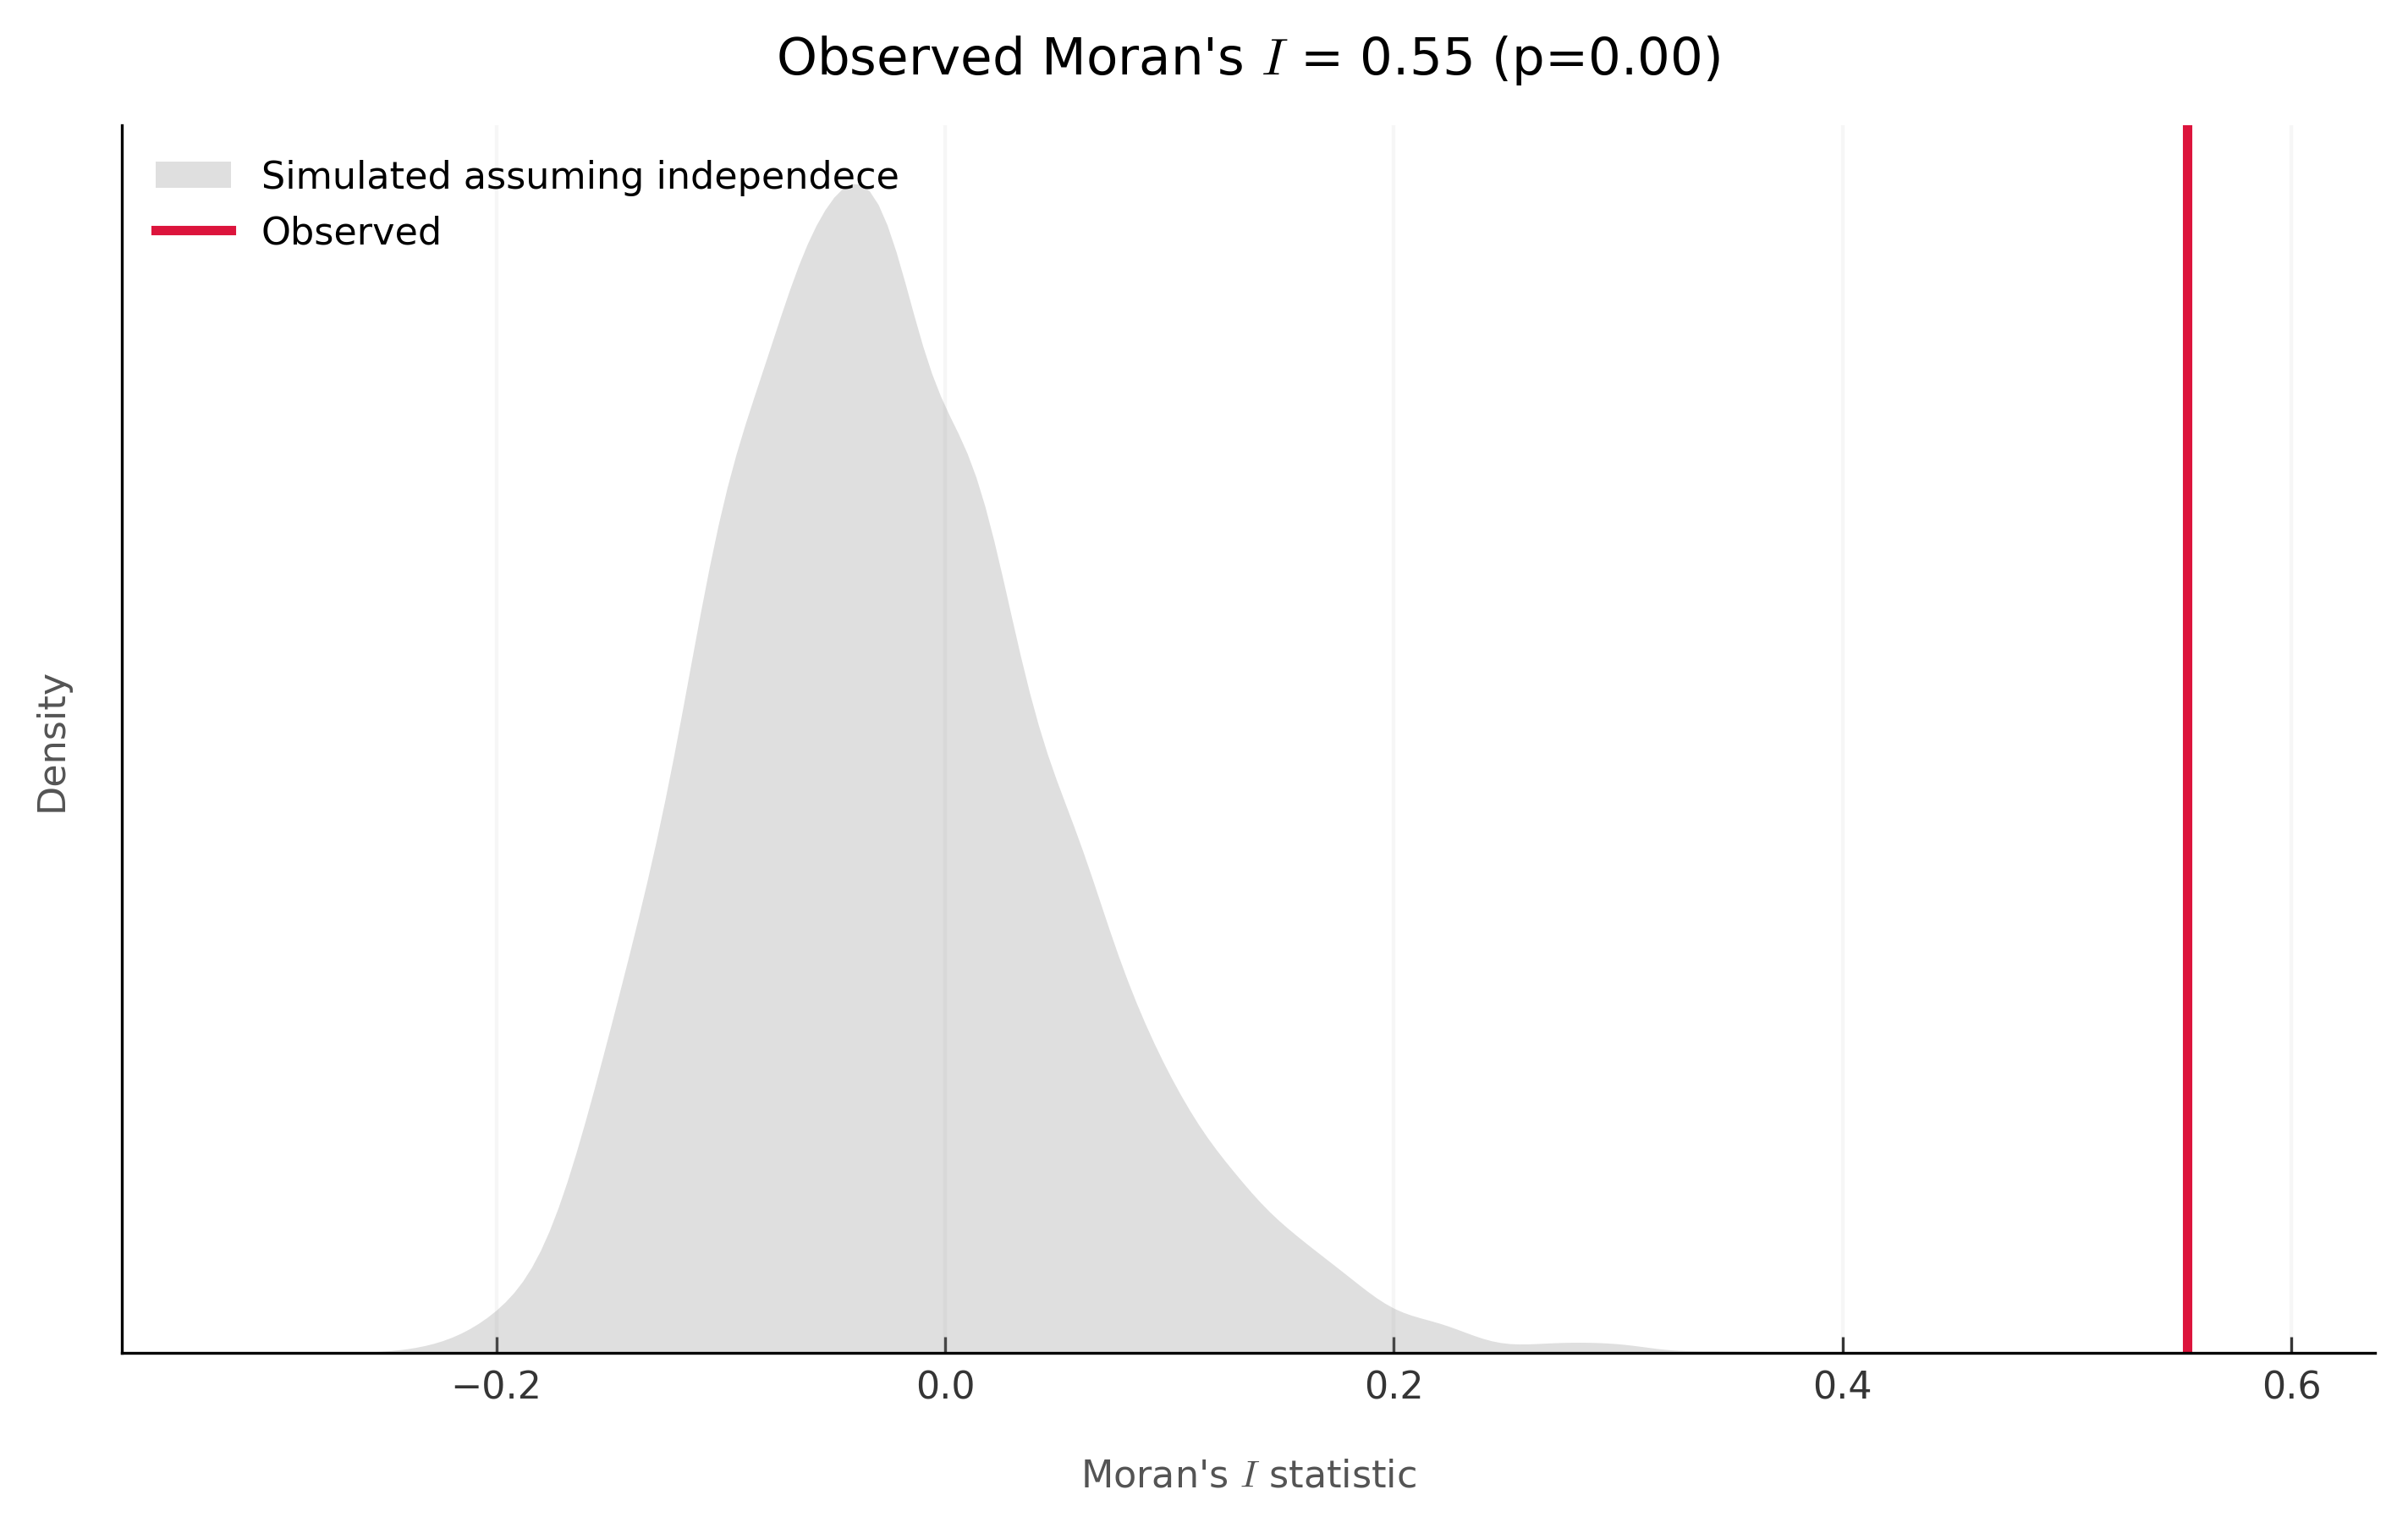

In [ ]:
moran_i = esda.Moran(
    y=non_na_RGT_geodata_europe["RGT"], 
    w=five_nearest_weighting,
    permutations=10_000,
)
fig, ax = plt.subplots()
seaborn.kdeplot(
    moran_i.sim,
    fill=True,
    color="grey",
    edgecolor="none",
    label="Simulated assuming independece",
    ax=ax,
    zorder=1,
)
ax.axvline(
    x=moran_i.I, 
    color="crimson",
    linewidth=2,
    label="Observed",
)
ax.grid(True, axis="x", zorder=-3)
ax.set_title(f"Observed Moran's $I$ = {moran_i.I:.2f} (p={moran_i.p_norm:.2f})", weight="normal")
ax.set_xlabel("Moran's $I$ statistic")
ax.set_yticks([])
ax.legend(loc="upper left")
plt.margins(x=0.1)
plt.show()

The observed Moran's Global $I$ far exceeds the range of values simulated under a CSR assumption, so indeed there seems to be some (statistically robust) RGT clustering going on.

But how do we know which choice of $K$, i.e., the number of neighbours considered to have (substantially) influences an observation? We can get to a theoretically-informed starting point by considering that most countries have around two border-contiguous neighbours and maybe an island they interact closely with. 

We can also get an emperically informed estimate by performing a sensitivity of how Global Moran's $I$ changes as we vary the number of neighbours considered.

/work/Spatial Analytics/SpatialTrust/venv/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


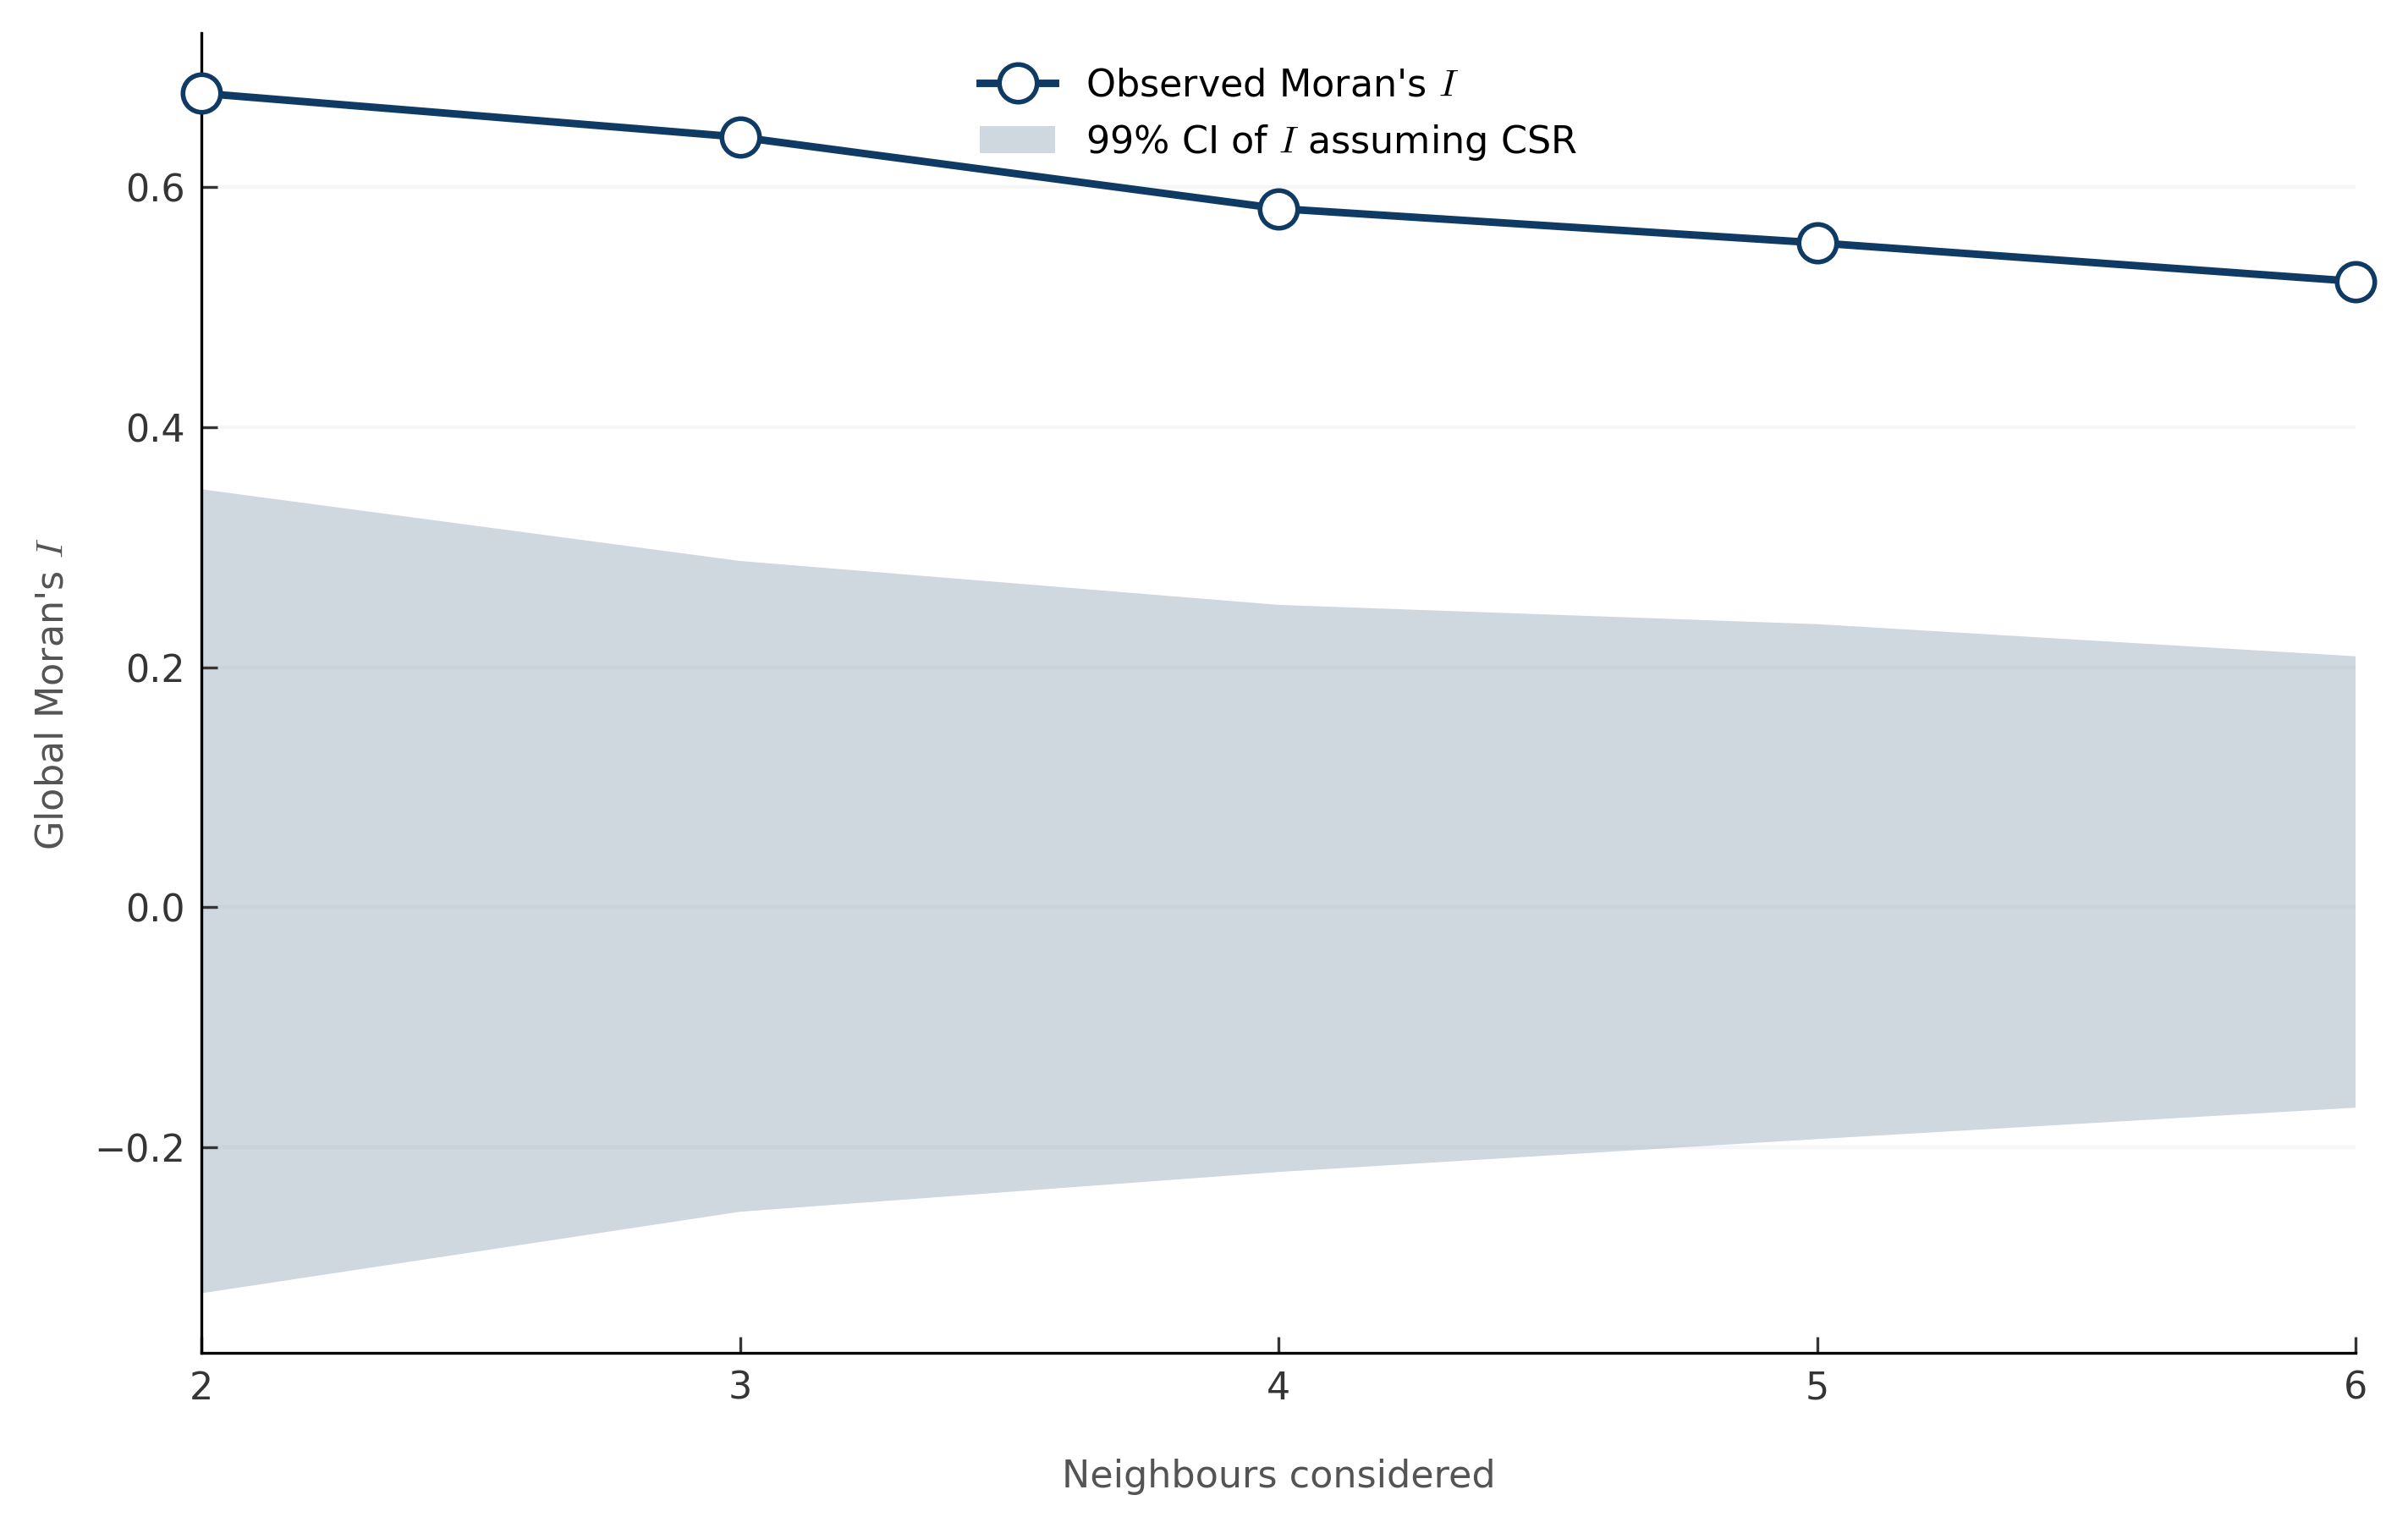

In [ ]:
def weighting_sensitivity_analysis(geodata, n_permutations=10_000):
    parameter_options = range(2, 6 + 1)
    moran_results = []
    for n_neighbours in parameter_options:
        weights = get_weights(
            data=geodata.copy(),
            criterion_function=libpysal.weights.KNN,
            args=dict(k=n_neighbours),
        )

        moran_results.append(esda.Moran(
            y=geodata["RGT"], 
            w=weights,
            permutations=n_permutations,
        ))
    
    plt.plot(
        parameter_options, 
        [result.I for result in moran_results],
        marker="o",
        markersize=8,
        markerfacecolor="white",
        clip_on=False,
        label="Observed Moran's $I$",
        zorder=10,
    )
    plt.fill_between(
        parameter_options, 
        [np.quantile(result.sim, 0.005) for result in moran_results],
        [np.quantile(result.sim, 0.995) for result in moran_results],
        alpha=0.2,
        zorder=-1,
        label="99% CI of $I$ assuming CSR",
    )
    plt.xlabel("Neighbours considered")
    plt.ylabel("Global Moran's $I$", labelpad=5)
    plt.xticks(range(1, max(parameter_options) + 1), [val if val in parameter_options else "" for val in range(1, max(parameter_options) + 1)])
    plt.xlim(min(parameter_options), max(parameter_options))
    plt.legend(
        loc="upper center",
    )
    plt.savefig(OUTPUT_PATH / "sensitivity_analysis.png", bbox_inches="tight")
    plt.show()

weighting_sensitivity_analysis(
    geodata=non_na_RGT_geodata_europe,
)

Although the observed (Global) Moran's $I$ is higher when considering only three neighbours, as compare to five, larger values of $I$ are also more likely under a CSR assumption (denoted by the CI envelope), simply due fewer degress of freedom, statistically speaking. 

Arguably, using five neighbours identifies more statistically robust clustering, seeing as the $I$-statistic is only slightly lower than for three neighbours, but the envelope of simulated values under CSR is markedly narrower, indicating that, comparatively, $K=5$ has a higher signal-to-noise ratio.

## Local Moran's $I$

Whereas Global Moran's $I$ can give us an indication as to _whether_ there is spatial clustering going on, it does not tell us _where_ that clustering is going on.

To address this, we can turn to Local Moran's $I$ (a so-called LISA: local indicator of spatial association), where we compute an $I$ statistic for each observation (i.e., country) and compare it to the observation that would be expected under a CSR. This gives, for each observation, an indication of whether that particular observation is more similar to its surroundings than expected under CRS (i.e., clustering), or whether it clashes with observations around it (i.e., scattering).

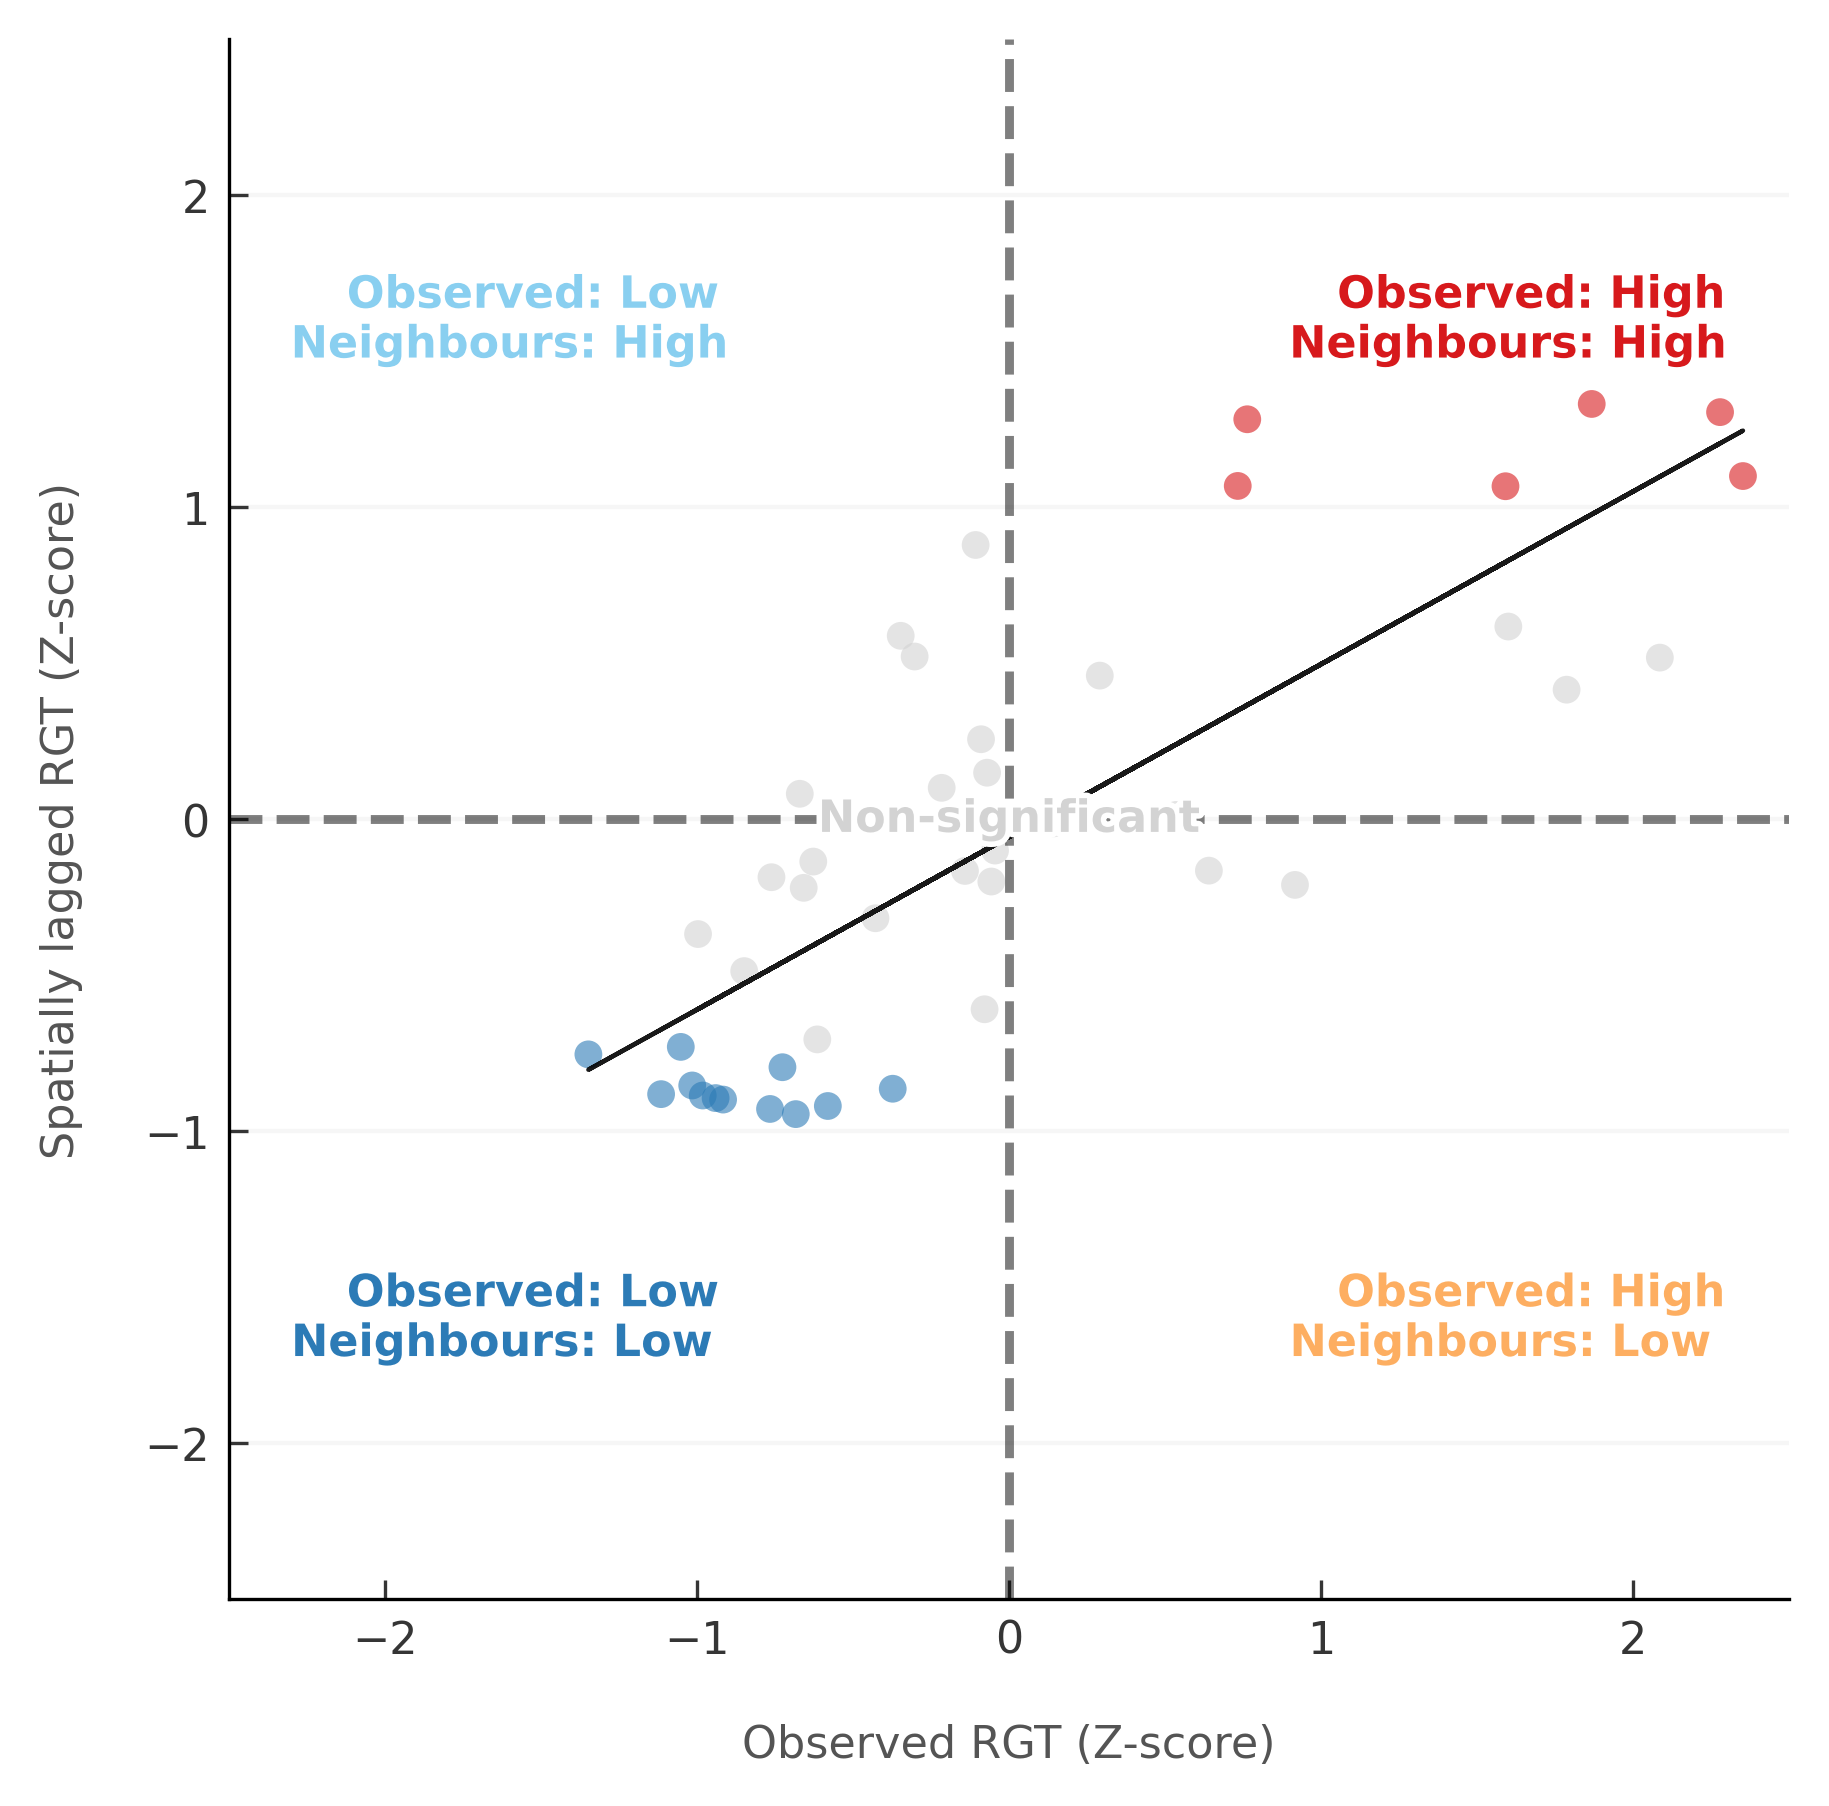

In [ ]:
def local_moran_analysis(weights, n_permutations=10_000):
    return esda.Moran_Local(
        y=weights.origin_geodata["RGT"], 
        w=weights,
        transformation="r",
        permutations=n_permutations,
    )

def local_moran_scatter(local_moran, pseudo_p_threshold):
    ax = local_moran.plot_scatter(
        crit_value=pseudo_p_threshold,
        scatter_kwds=dict(
            edgecolor="none",
            s=25,
            clip_on=False,
        ),
        fitline_kwds=dict(
            linewidth=0.8,
        ),
    )

    label_options = {
        "Non-significant"                       : "lightgrey",
        "   Observed: Low\nNeighbours: Low "    : "#2C7BB6",
        "   Observed: High\nNeighbours: Low "   : "#FDAE61",
        "   Observed: Low\nNeighbours: High"    : "#89CFF0",
        "   Observed: High\nNeighbours: High"   : "#D7191C",
    }
    corner_extent = 1.6
    for (label, color), position in zip(label_options.items(), [
        dict(xy=(0, 0)),
        dict(xy=(-corner_extent, -corner_extent)),
        dict(xy=(corner_extent, -corner_extent)),
        dict(xy=(-corner_extent, corner_extent)),
        dict(xy=(corner_extent, corner_extent)),
    ]):
        ax.annotate(
            text=label,
            xy=position["xy"],
            ha="center",
            va="center",
            color=color,
            size=8,
            weight="bold",
            path_effects=[patheffects.withStroke(linewidth=2, foreground="white")],
        )

    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_title("")
    ax.set_xlabel("Observed RGT (Z-score)")
    ax.set_ylabel("Spatially lagged RGT (Z-score)")
    plt.savefig(OUTPUT_PATH / "moran_simulation_scatter.png", bbox_inches="tight")
    plt.show()

local_moran = local_moran_analysis(
    weights=get_weights( 
        data=non_na_RGT_geodata_europe,
        criterion_function=libpysal.weights.KNN,
        args=dict(k=5), # weights matrix based on 5 nearest neighbours
    ),
    n_permutations=100_000 # run 100k permutations
)

pseudo_p_thresold = esda.fdr( # filter pseudo p-values for significance at alpha=0.05 with FDR correction
    pvalues=local_moran.p_sim,
    alpha=0.05,
)

local_moran_scatter(
    local_moran,
    pseudo_p_threshold=pseudo_p_thresold,
)

We can illustrate the results of the analysis with a scatterplot showing RGT Z-scores against spatially lagged RGT Z-scores (derived from neighbouring observations weighted by KNN).

Countries fall into four quadrants: 
- I) observed level of RGT is high, the same is true of surroundings countries, 
- II) RGT is high, neighbours have low RGT, 
- III) RGT is low, also low for neighbouring countries and 
- IV) RGT is low, but RGT of surrounding countries is high

where quadrants I and III signify clustering, whereas quadrants II and IV point to "out-of-place" observations that clash with their surroundings.

Each quadrant is associated with a color, but in order to avoid interpreting stochastic noise, observations are filtered for statistical significance such that only observations that are statistically unlikely to have arisen from a CSR process are colored. 
Tests for statistical significance were performed based on pseudo p-values at $\alpha = 0.05$ and corrected for multiple comparisons using the false discovery rate (FDR) correction.

We see that there's a swarm of seven countries who have high relative levels of generalized trust and share that with their neighbours, forming a (spatial) cluster of RGT.
Conversely, we have a cluster of fourteen countries showing remarkably low levels of RGT and share that with their immediate neighbours. Finally, there's a single country in quadrant III which passes our set threshold for statistical significance, which means that it differs from its neighbours by displaying markedly lower levels of RGT.

This is all well and good, but is very difficult to meaninfully interpret without "unembedding" into the geospatial domain. To rectify this, we can visually the geospatial distribution of assigned quadrants with a choropleth map.

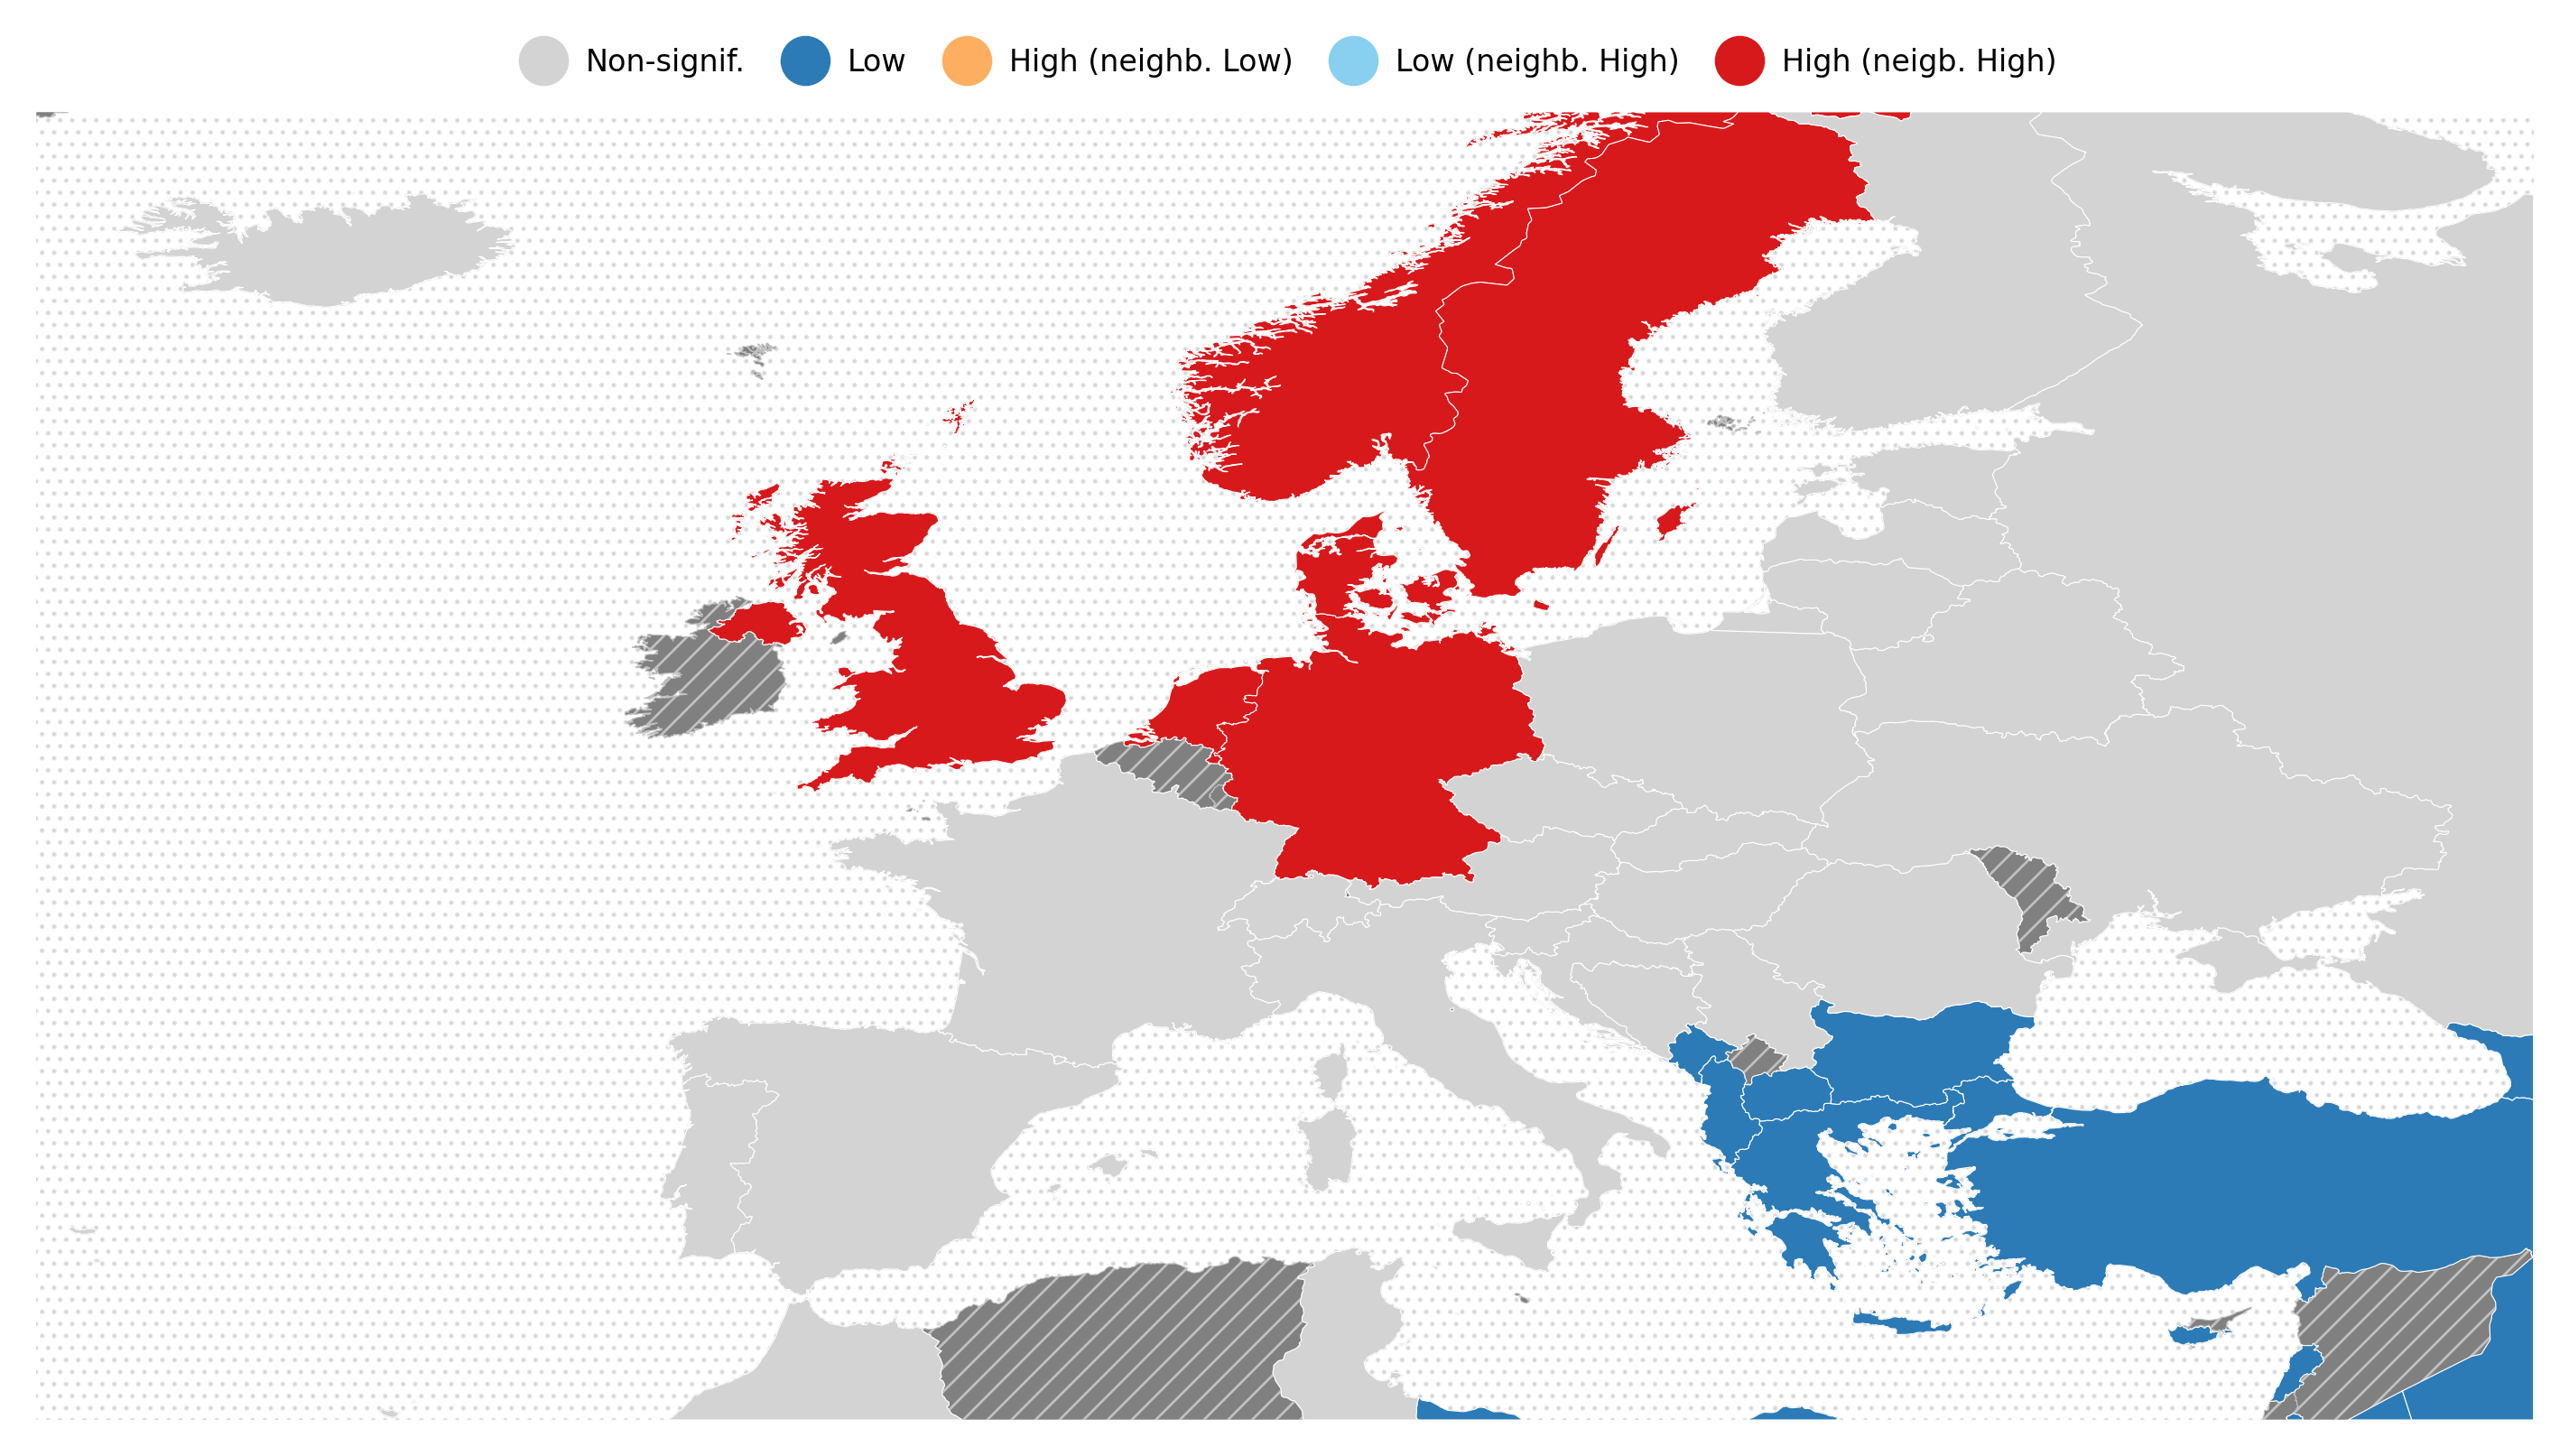

In [ ]:
def local_moran_choropleth(local_moran, pseudo_p_threshold, geodata):
    ax = geodata.plot(
        color="grey",
        edgecolor="silver",
        hatch=5 * "/",
        linewidth=0.2,
        zorder=0,
    )
    local_moran.plot(
        local_moran.w.origin_geodata,
        crit_value=pseudo_p_threshold,
        edgecolor="white",
        linewidth=0.2,
        zorder=1,
        ax=ax,
    )
    ax.margins(x=0, y=0)
    add_sea_pattern(ax)
    add_minimap(geodata, ax=ax)

    label_options = {
        "Non-signif."           : "lightgrey",
        "Low"                   : "#2C7BB6",
        "High (neighb. Low)"    : "#FDAE61",
        "Low (neighb. High)"    : "#89CFF0",
        "High (neigb. High)"    : "#D7191C",
    }
    ax.legend(
        handles=[lines.Line2D([0], [0], marker="o", markerfacecolor=color, markeredgecolor="none", markersize=10, linewidth=0, label=label) for label, color in label_options.items()],
        ncol=len(label_options),
        loc="upper center",
        bbox_to_anchor=(0.5, 1.07),
        fontsize=6,
        handletextpad=0.4,
        columnspacing=1,
    )
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.savefig(OUTPUT_PATH / "moran_simulation_quadrant.png", bbox_inches="tight")
    plt.show()

local_moran_choropleth(
    local_moran,
    pseudo_p_threshold=pseudo_p_thresold,
    geodata=RGT_geodata_continental_europe,
)

From the choropleth map we see that the cluster of shared high RGT corresponds to the Nordic countries (as well as Germany and Belgium), whereas the low RGT cluster springs from the Eastern Mediterranean and bleeds into the Balkans. This forms a prominent RGT gradient stretching from the northwest to southeast. The one outlier is France which displays lower-than-median levels of RGT despite being surrounded (on one side) by high-RGT countries.